This notebook is designed to visualize the GaMMA result, like figures shown in https://github.com/AI4EPS/GaMMA/blob/master/docs/example_synthetic.ipynb

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyproj import Proj
import json
import pygmt

## Configs

In [2]:
center=(-178, -19)

In [3]:
with open("../data/stations.json") as json_file:
    stations_raw = json.load(json_file)
stations = pd.DataFrame(columns=["id", "x(km)", "y(km)", "z(km)","longitude","latitude"])
proj = Proj(
    f"+proj=sterea +lon_0={center[0]} +lat_0={center[1]} +units=km")
for key in stations_raw:
    row = stations_raw[key]
    x, y = proj(longitude=row["longitude"], latitude=row["latitude"]) # pylint: disable=unpacking-non-sequence
    z = -row["elevation_m"]/1000
    stations.loc[len(stations)] = [key, x, y, z,row["longitude"],row["latitude"]]

In [4]:
stations.head()

,id,x(km),y(km),z(km),longitude,latitude
0,YL.B01W..HH,312.034960,-118.762866,1.723,-175.018005,-20.048300
1,YL.B03..BH,273.751404,-106.295665,2.015,-175.385498,-19.941401
2,YL.B06..BH,226.215212,-89.088659,2.201,-175.841400,-19.792000
3,YL.C02..BH,246.018470,-157.680054,2.062,-175.643494,-20.408899
4,YL.C04..BH,217.472386,-132.352162,2.197,-175.919800,-20.183599


## load data

In [5]:
df_global=pd.read_csv('../example_res/picks_global.csv',sep='\t',index_col=0,comment='#')
df_global = df_global.reset_index(drop=True)
# map event_index to from 3,4,7,6,5,2,1,0 to 0,1,2,3,4,5,6,7
df_global['event_index']=df_global['event_index'].map({3:0,4:1,7:2,6:3,5:4,2:5,1:6,0:7})

df_catalog_global=pd.read_csv('../example_res/catalogs_global.csv',sep='\t',index_col=0,comment='#')
# timestamp to datetime
df_global['timestamp']=pd.to_datetime(df_global['timestamp'])
df_catalog_global['time']=pd.to_datetime(df_catalog_global['time'])
# join df_global and df_catalog_global on event_index
df_global=df_global.join(df_catalog_global.set_index('event_index'),on='event_index',rsuffix='_catalog')
# join df_global and distance in station on id
df_global=df_global.join(stations.set_index('id'),on='id',rsuffix='_station')

df_catalog_local=pd.read_csv('../example_res/catalogs_local.csv',sep='\t',index_col=0,comment='#')

df_catalog_local['time']=pd.to_datetime(df_catalog_local['time'])

# join df_global and df_catalog_local on event_index, with suffix _local
df_global=df_global.join(df_catalog_local.set_index('event_index'),on='event_index',rsuffix='_local')

In [6]:
# split df_global with event_index into a list of dataframes
df_global_list = [df_global[df_global['event_index'] == i].copy() for i in df_global['event_index'].unique()]

# for each dataframe in df_global_list, calculate tshift=t_pick-t_catalog
# using .loc[row_indexer,col_indexer] = value syntax
for df in df_global_list:
    df.loc[:, 'tshift'] = df['timestamp'] - df['time']
    # convert tshift to seconds
    df.loc[:, 'tshift'] = df['tshift'].apply(lambda x: x.total_seconds())
    # calculate tshift_local=timestamp-time_local
    df.loc[:, 'tshift_local'] = df['timestamp'] - df['time_local']
    # convert tshift_local to seconds
    df.loc[:, 'tshift_local'] = df['tshift_local'].apply(lambda x: x.total_seconds())

In [7]:
df_global_list[0].iloc[0]

event_id                                  1_52318
id                                     YL.A05..BH
timestamp              2009-12-18 16:17:46.000002
amp                                      0.000001
type                                            p
prob                                          1.0
event_index                                     0
gamma_score                              0.114702
time                   2009-12-18 16:16:35.463000
x(km)                                  -44.810067
y(km)                                 -411.552467
z(km)                                   558.64312
magnitude                                     999
sigma_time                               0.994991
sigma_amp                                       0
cov_time_amp                                    0
gamma_score_catalog                          17.0
longitude                             -178.435709
latitude                               -22.715365
depth(m)                            558643.120329


In [8]:
ground_truth_mapper = {
    0: (pd.to_datetime("2009-12-18T16:16:17.690002"), -24.3559, -179.6035, 613.0488),
    1: (pd.to_datetime("2009-12-18T16:29:52.279999"), -21.9949, -179.1595, 709.6464),
    2: (pd.to_datetime("2009-12-26T00:58:03.370003"), -18.8106, -177.7439, 465.9037),
    3: (pd.to_datetime("2009-12-26T05:15:54.969999"), -20.4003, -175.5445, 168.4243),
    4: (pd.to_datetime("2010-01-16T16:16:10.889999"), -19.6456, -175.5606, 226.2806),
    5: (pd.to_datetime("2010-05-14T10:33:23.950001"), -20.1968, -177.1223, 494.8412),
    6: (pd.to_datetime("2010-06-05T10:56:55.099998"), -23.4167, -178.722, 550.8715),
    7: (pd.to_datetime("2010-06-29T08:16:13.949997"), -17.6654, -177.7512, 523.6898),
}

ground_truth_mapper


{0: (Timestamp('2009-12-18 16:16:17.690002'), -24.3559, -179.6035, 613.0488),
 1: (Timestamp('2009-12-18 16:29:52.279999'), -21.9949, -179.1595, 709.6464),
 2: (Timestamp('2009-12-26 00:58:03.370003'), -18.8106, -177.7439, 465.9037),
 3: (Timestamp('2009-12-26 05:15:54.969999'), -20.4003, -175.5445, 168.4243),
 4: (Timestamp('2010-01-16 16:16:10.889999'), -19.6456, -175.5606, 226.2806),
 5: (Timestamp('2010-05-14 10:33:23.950001'), -20.1968, -177.1223, 494.8412),
 6: (Timestamp('2010-06-05 10:56:55.099998'), -23.4167, -178.722, 550.8715),
 7: (Timestamp('2010-06-29 08:16:13.949997'), -17.6654, -177.7512, 523.6898)}

2.227001999999999 -179.6035


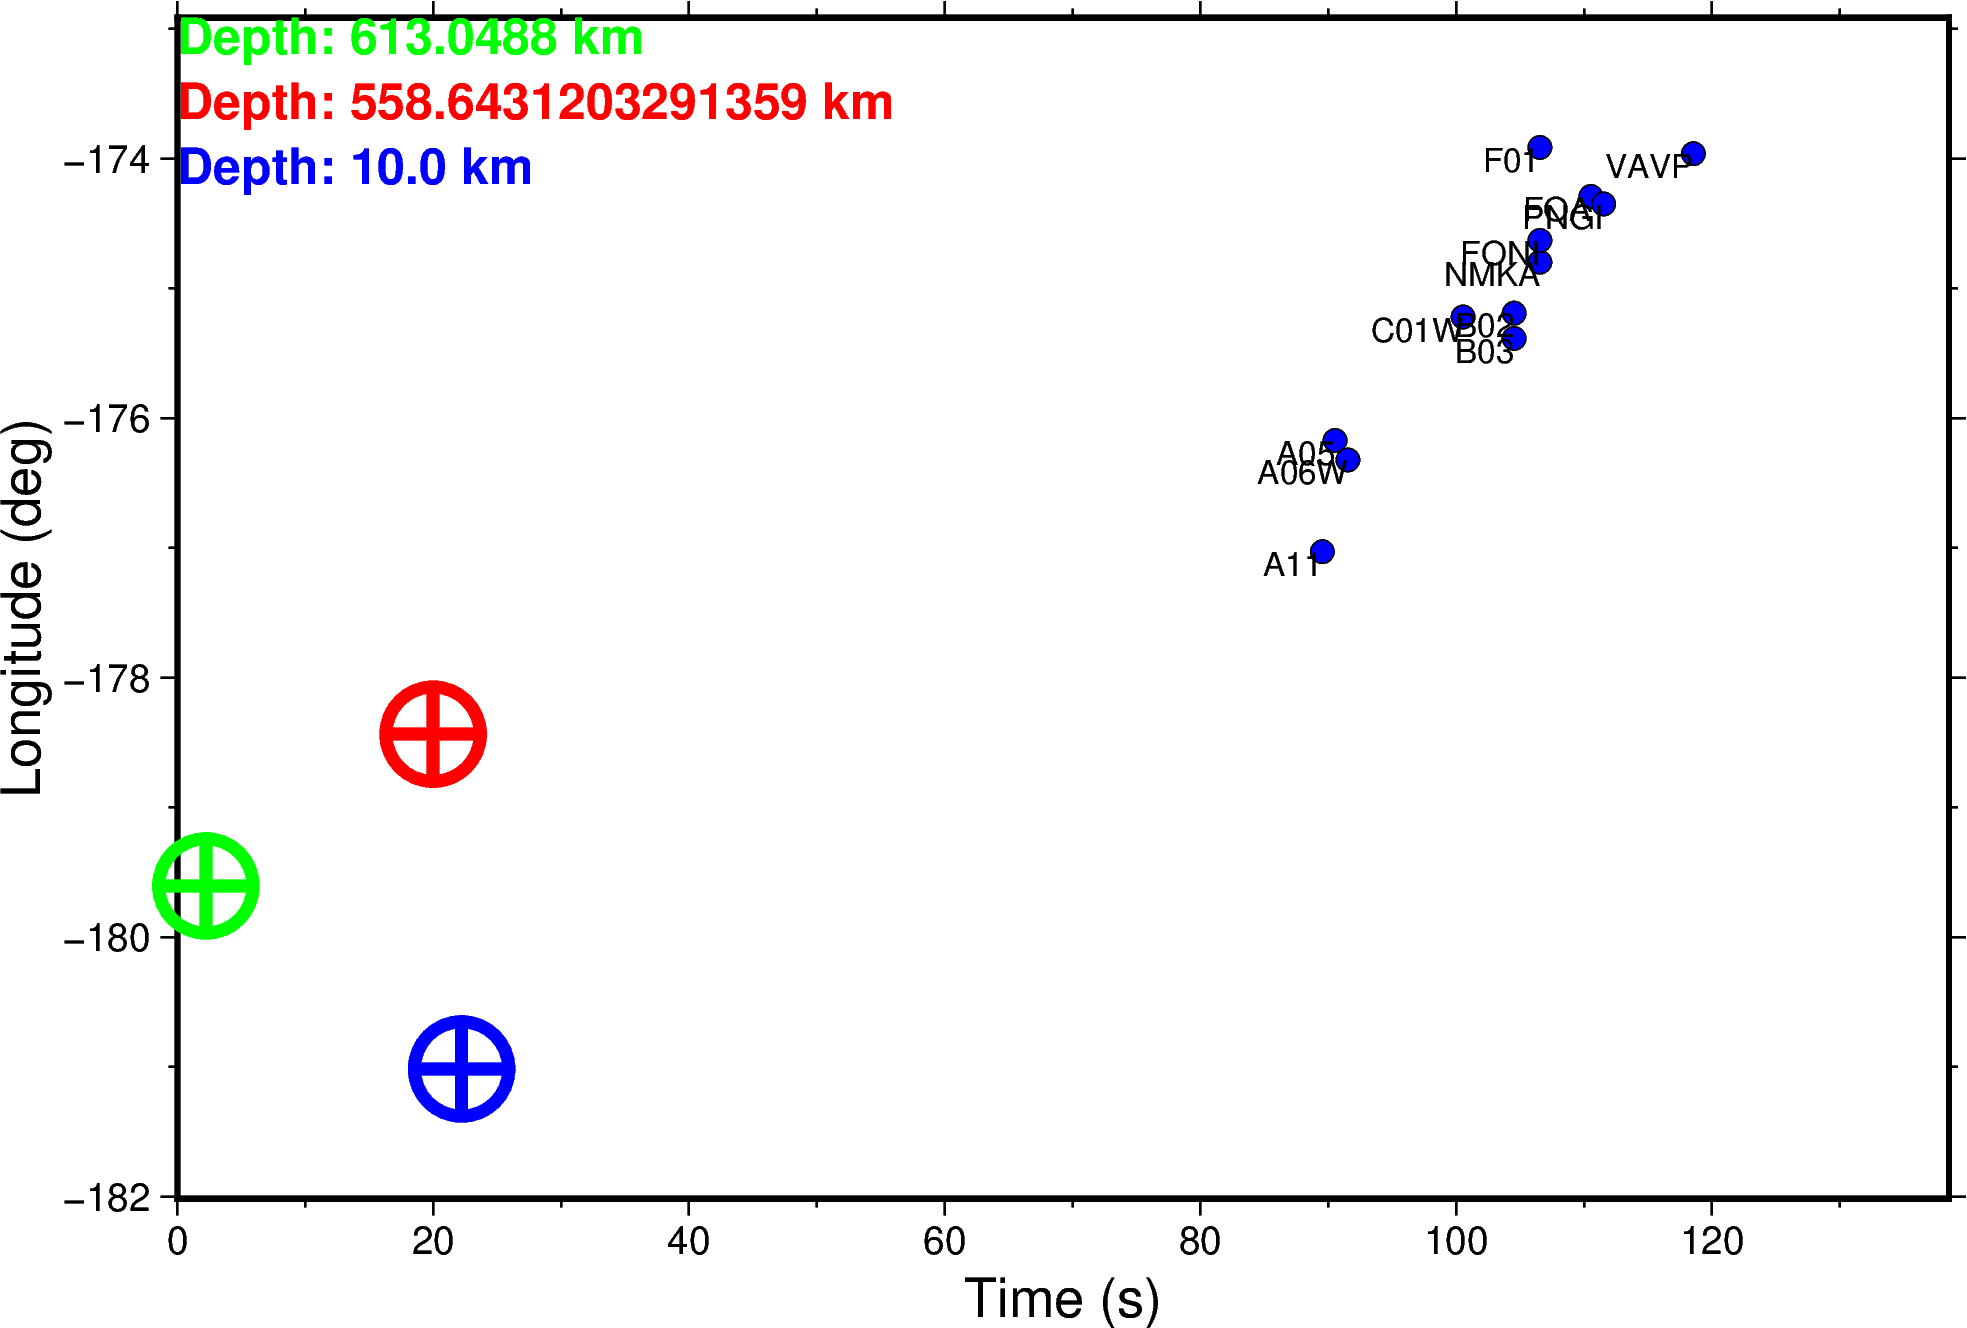

6.662998999999999 -179.1595


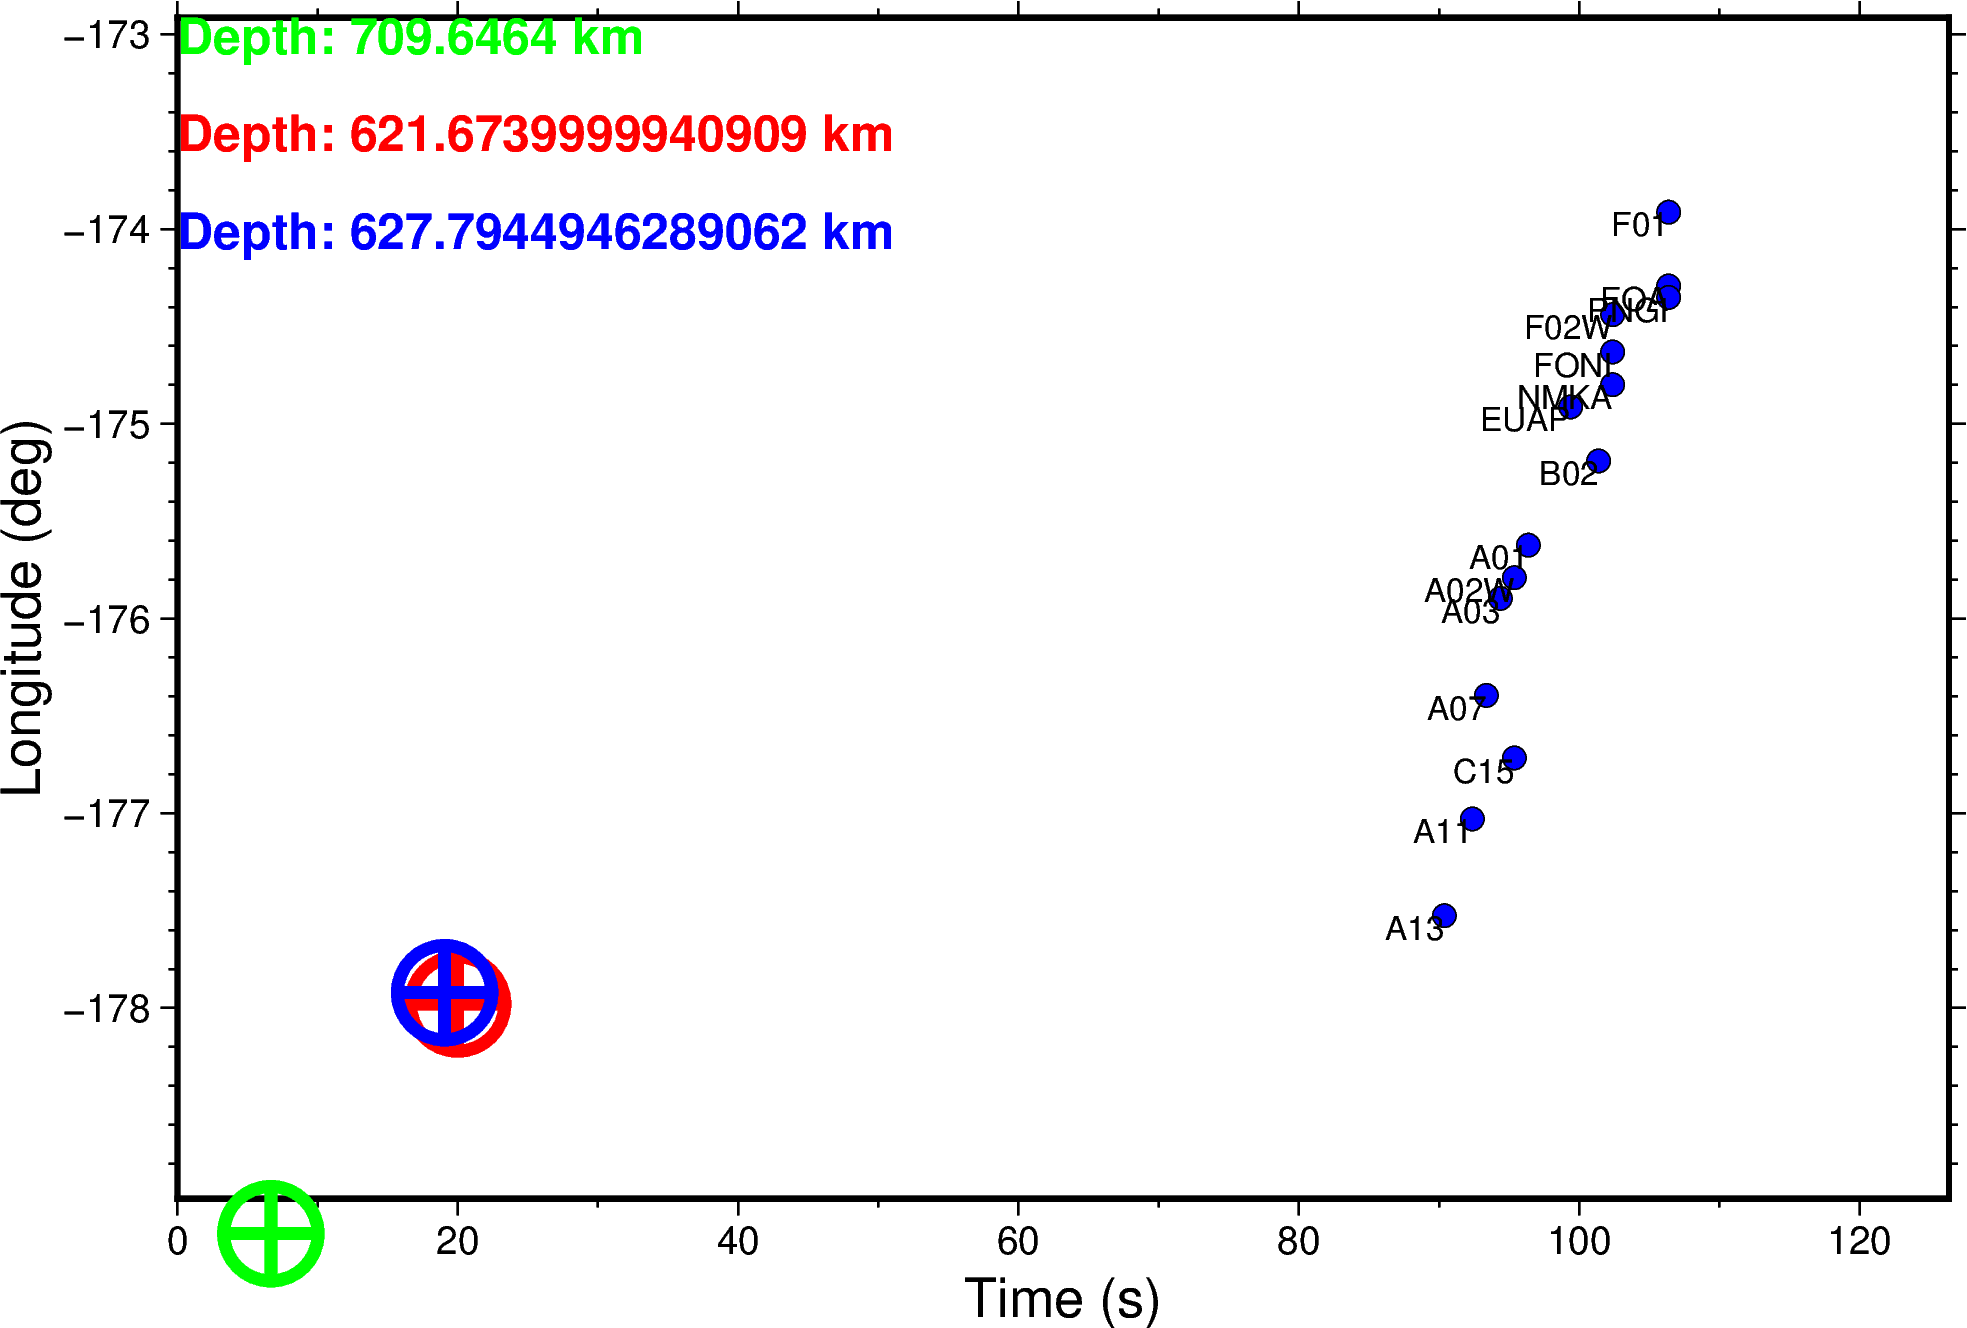

15.225003000000001 -177.7439


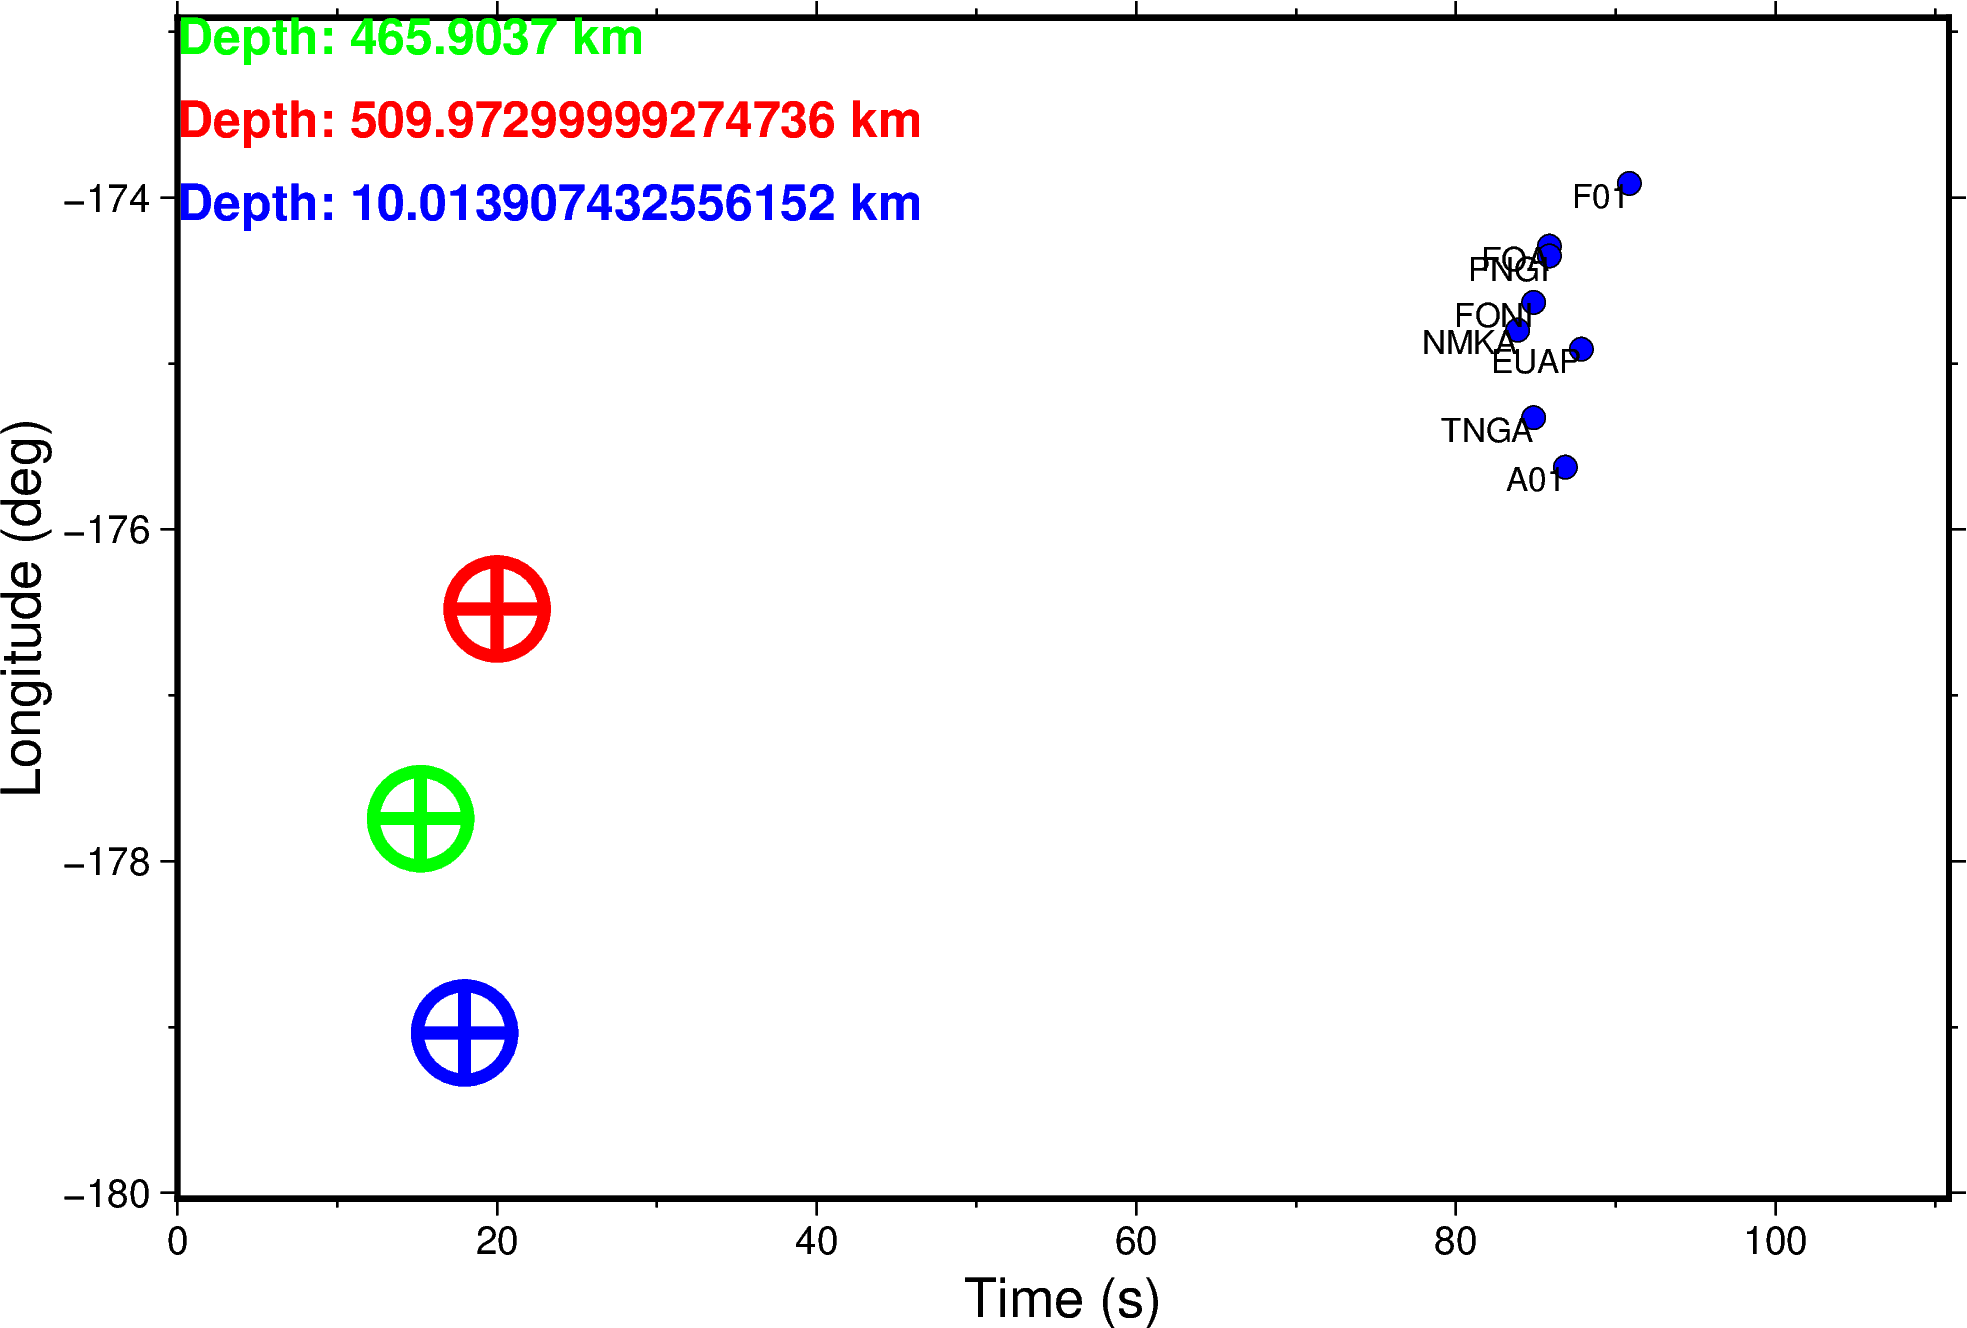

19.607999 -175.5445


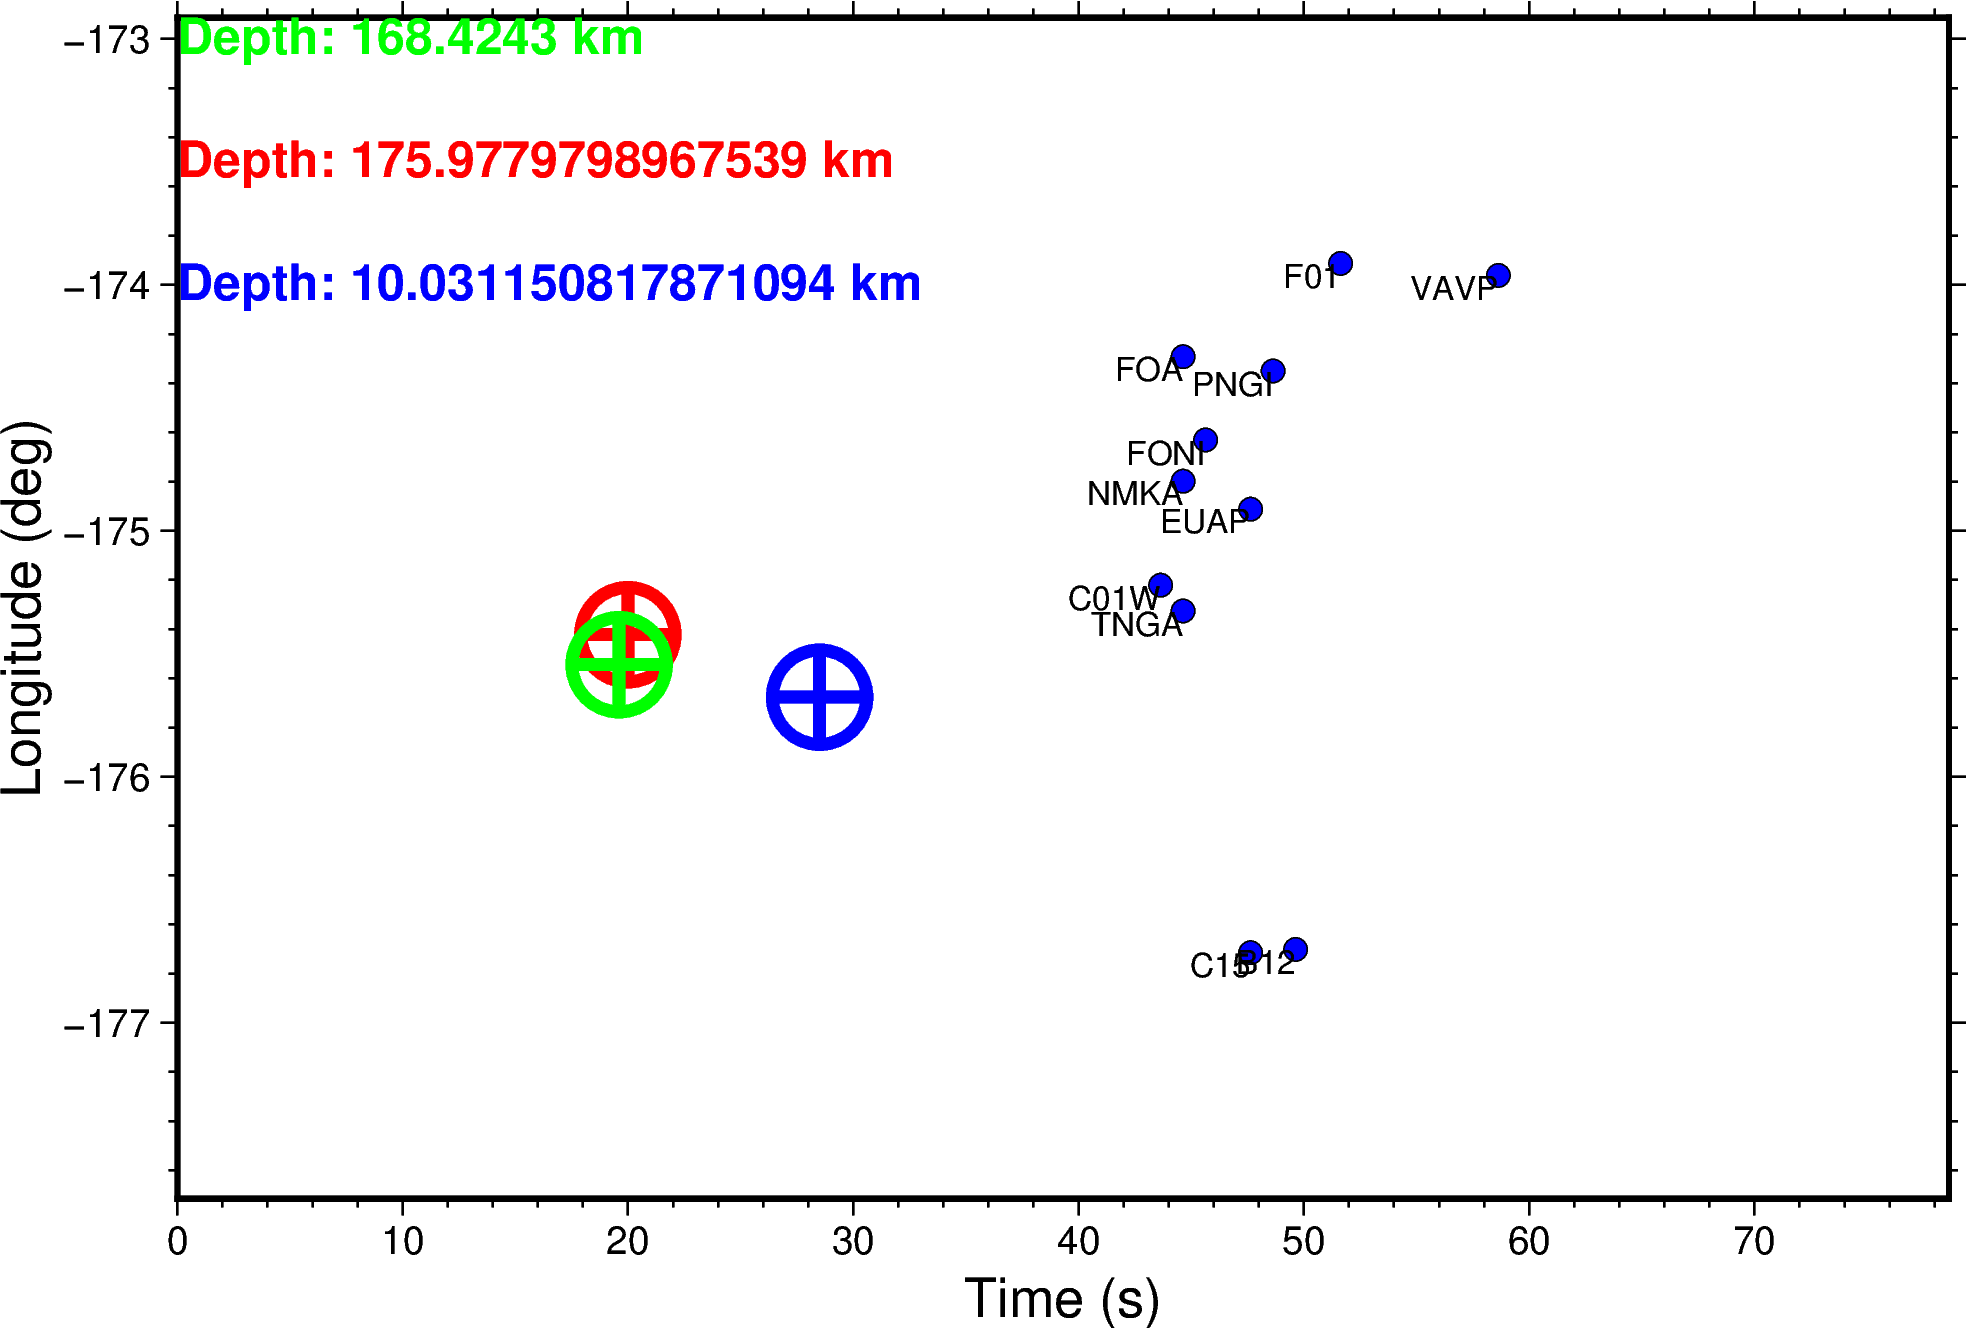

18.879999 -175.5606


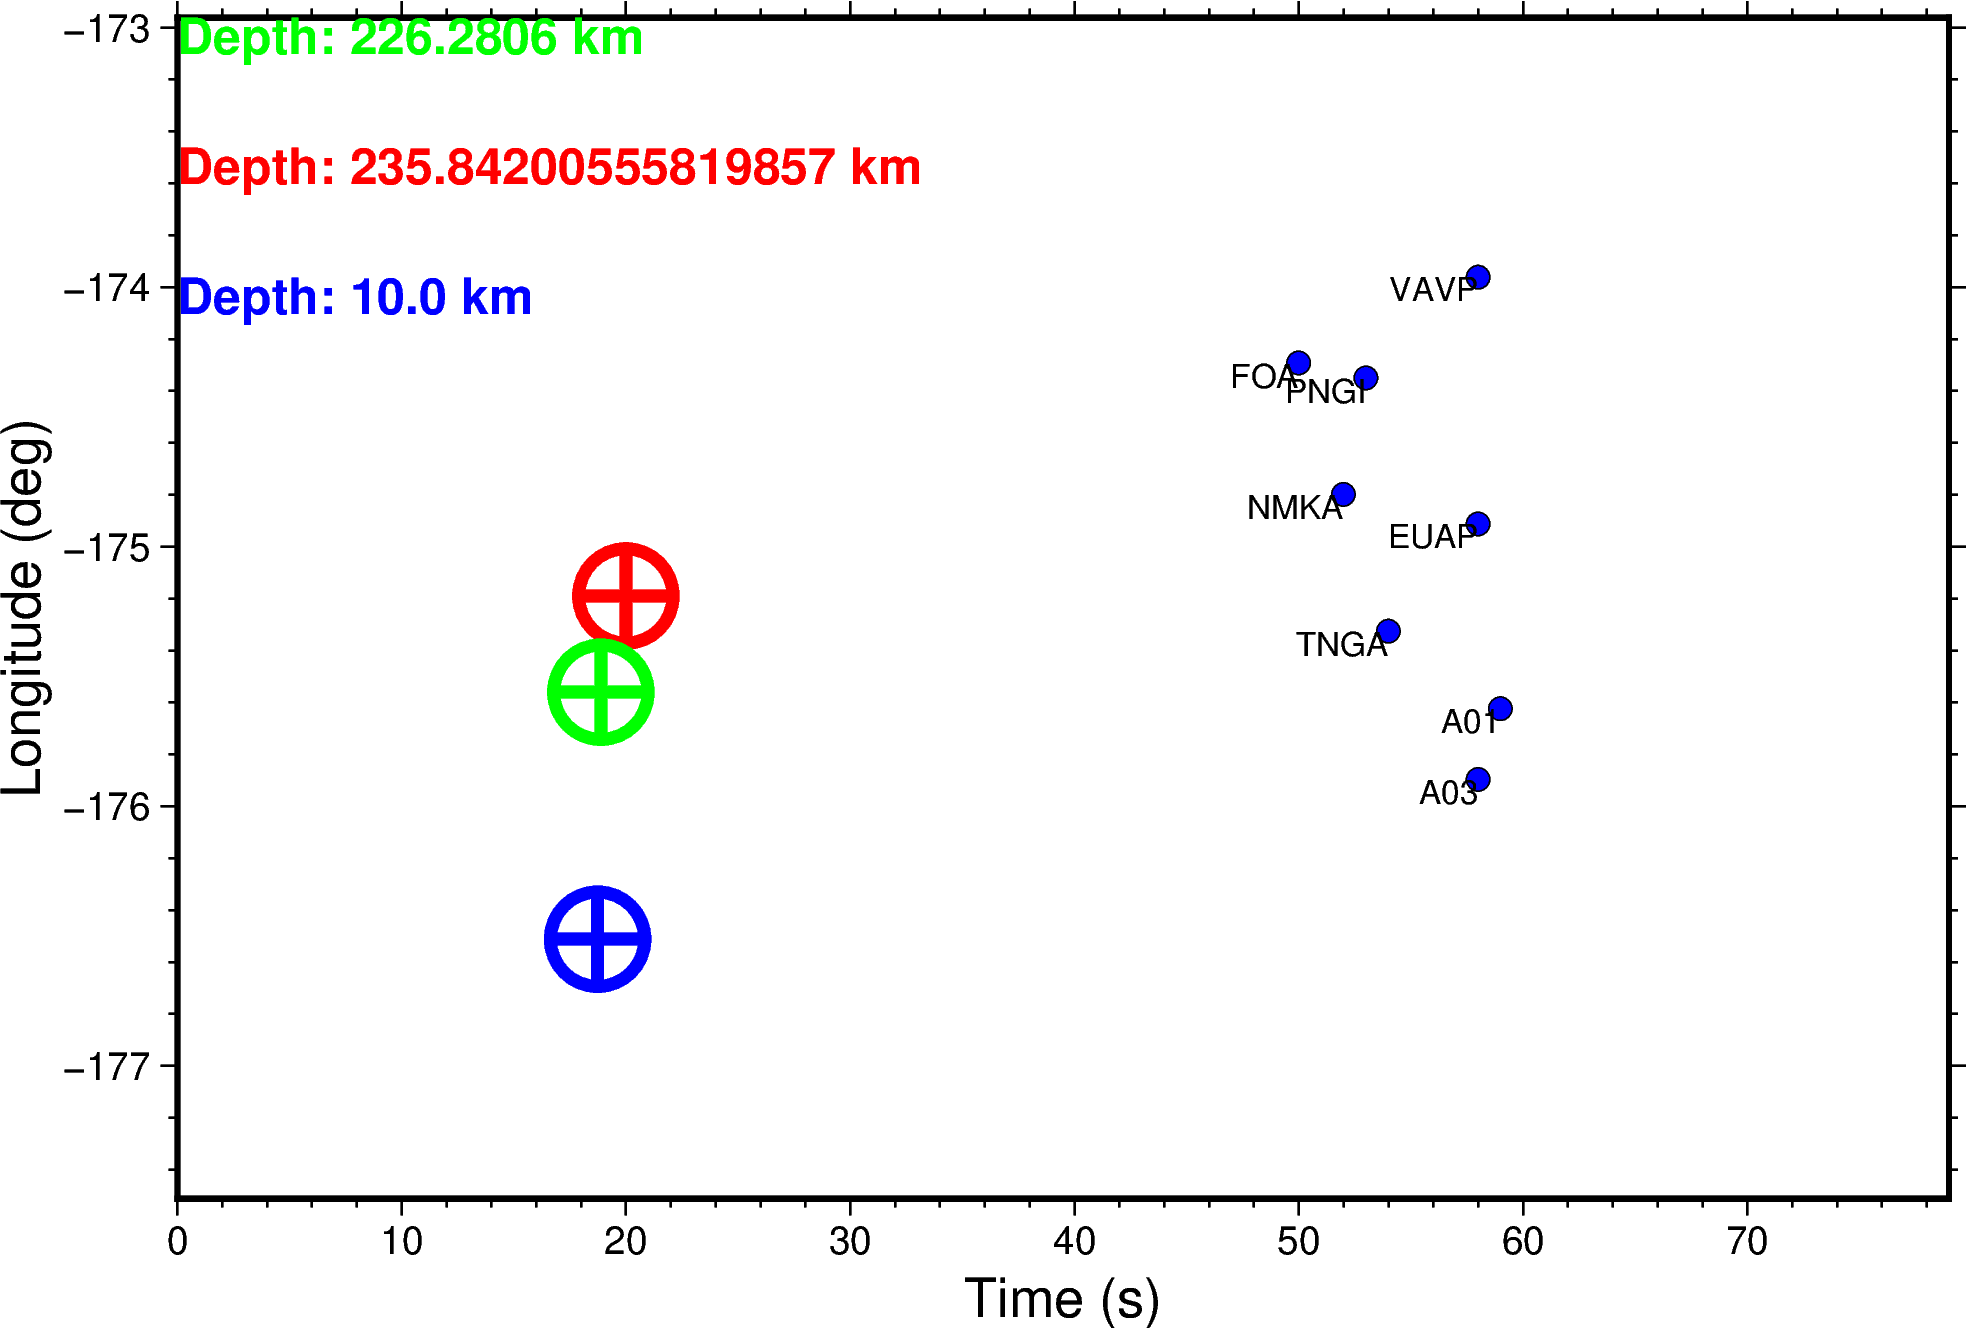

18.838001 -177.1223


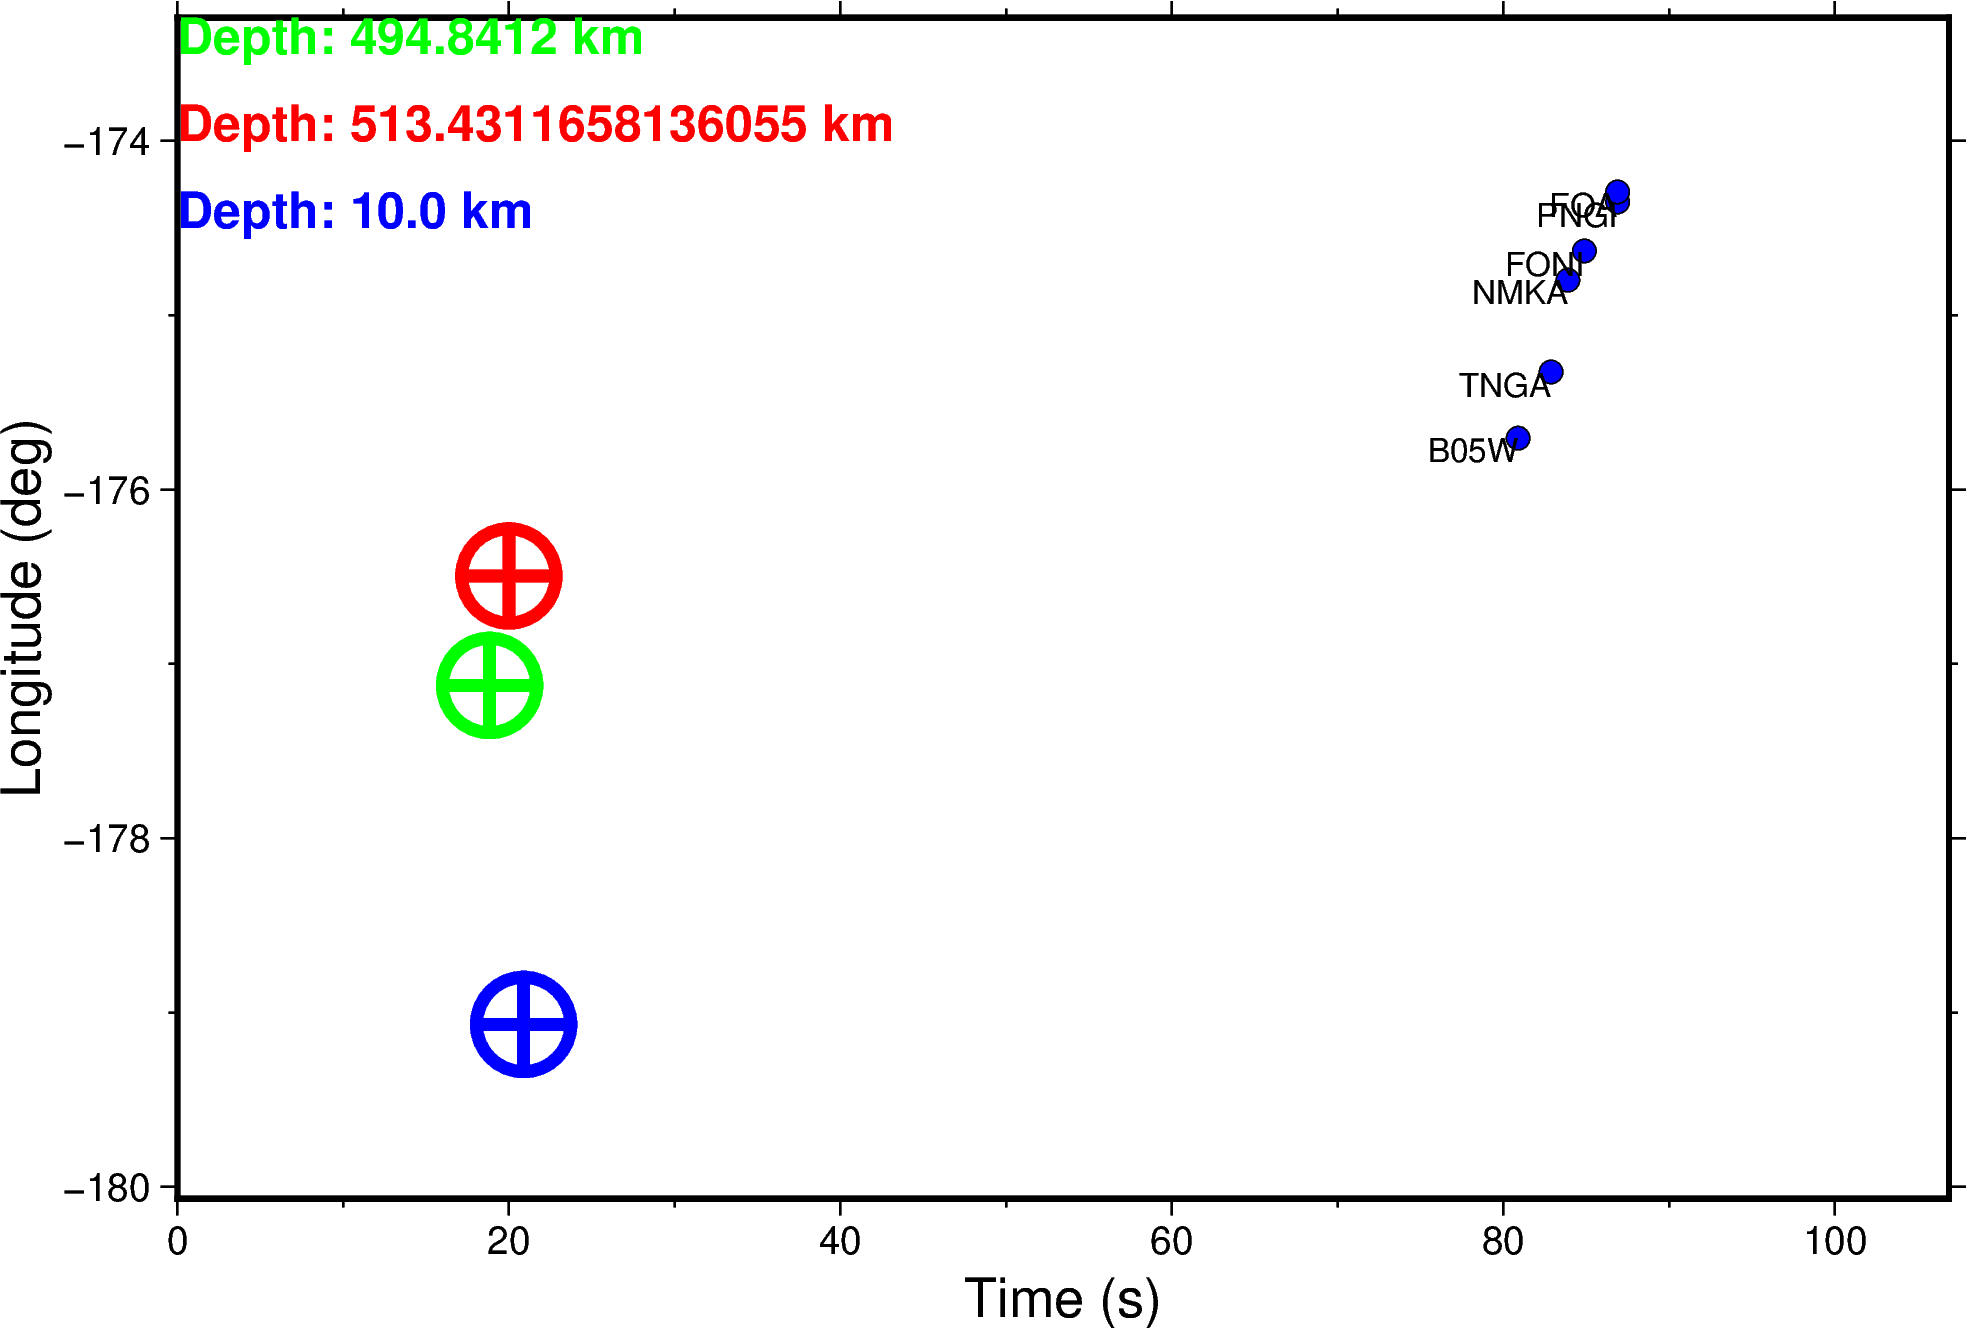

18.594998 -178.722


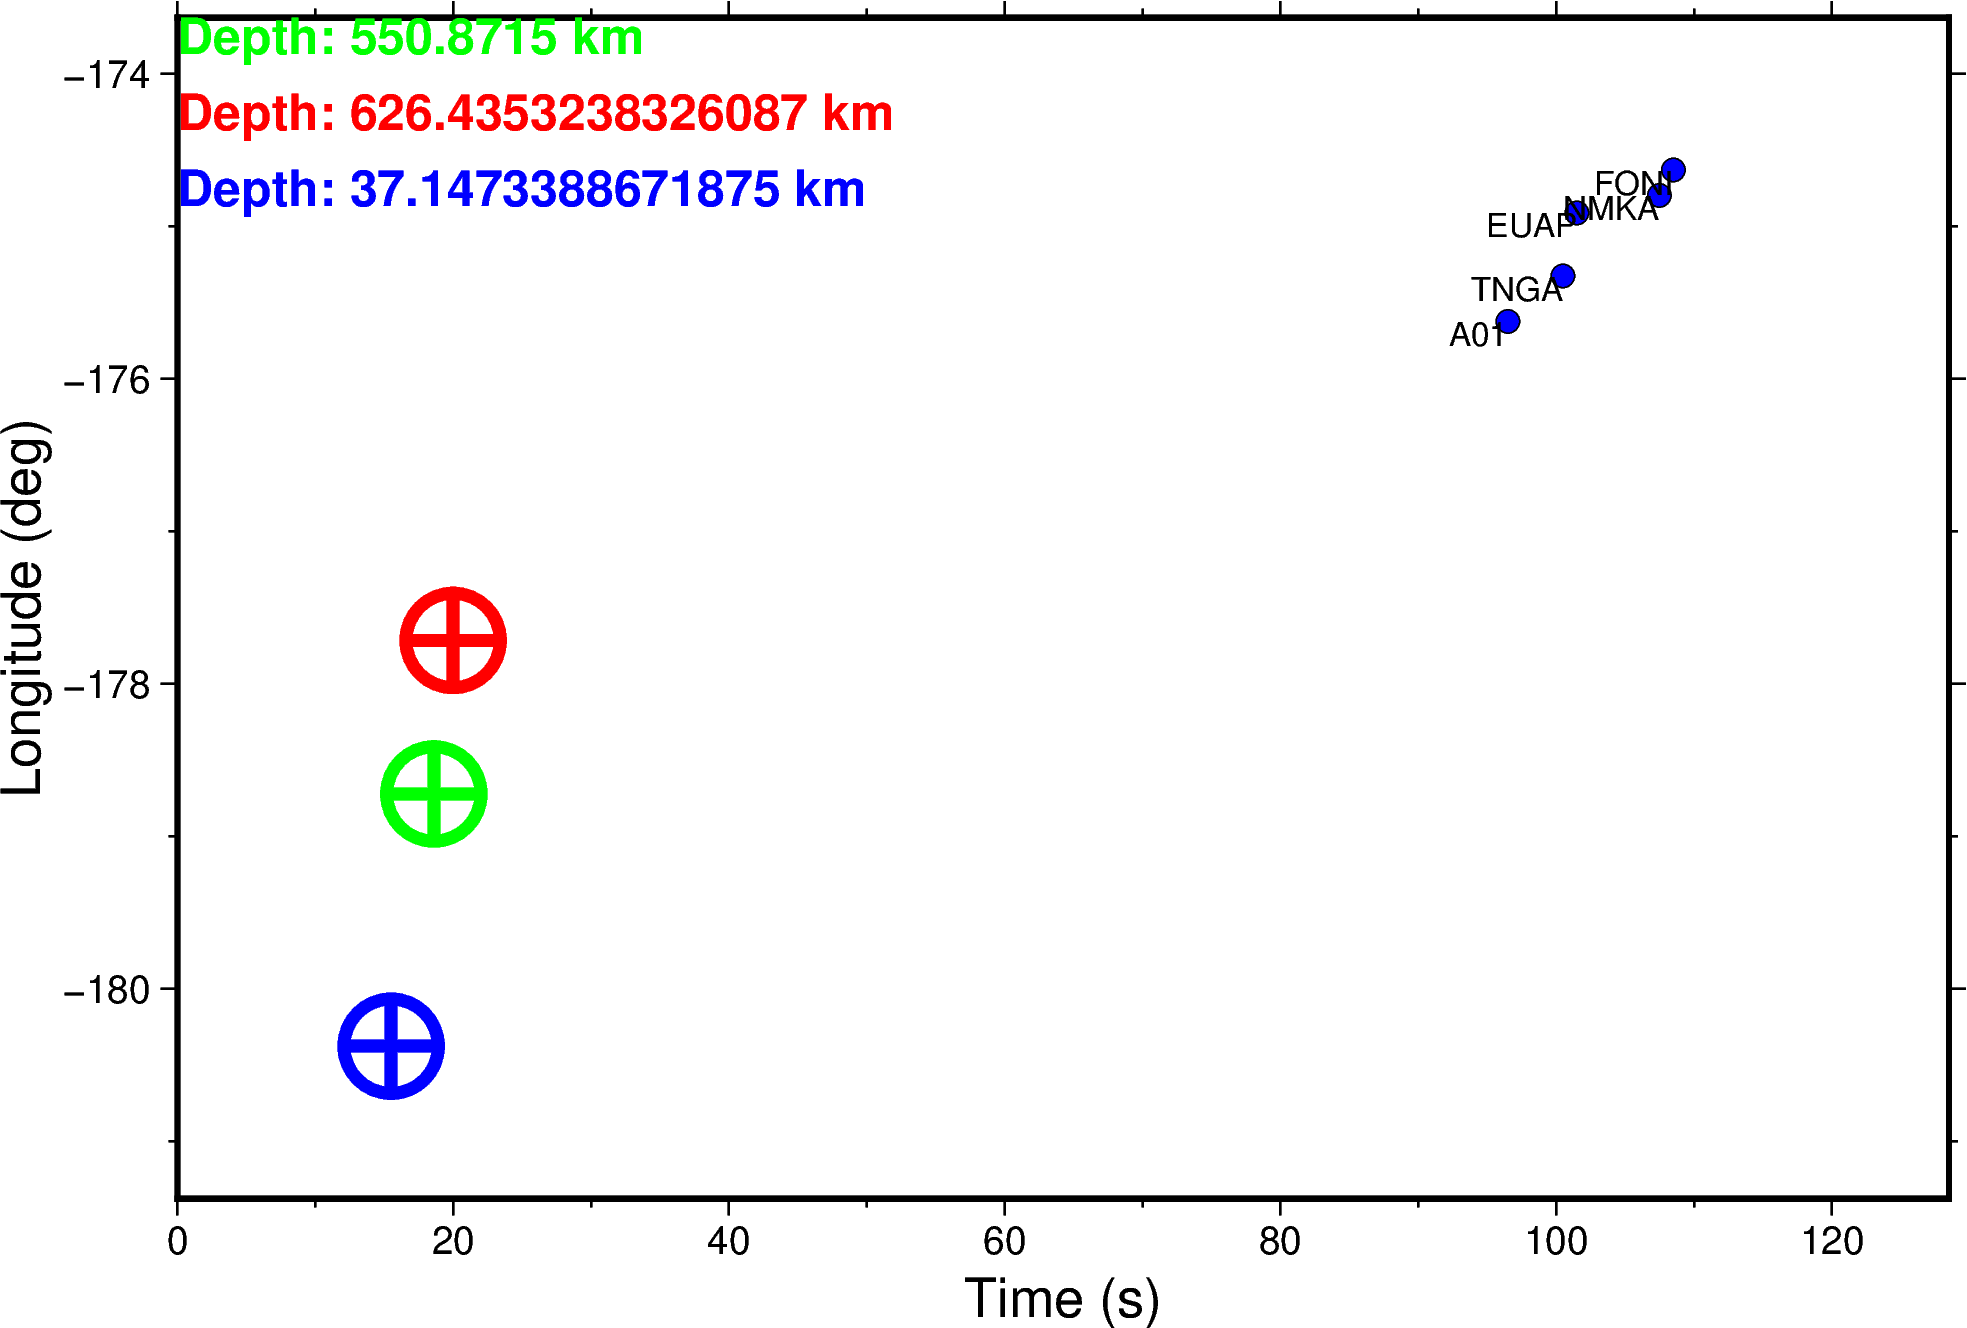

16.715997 -177.7512


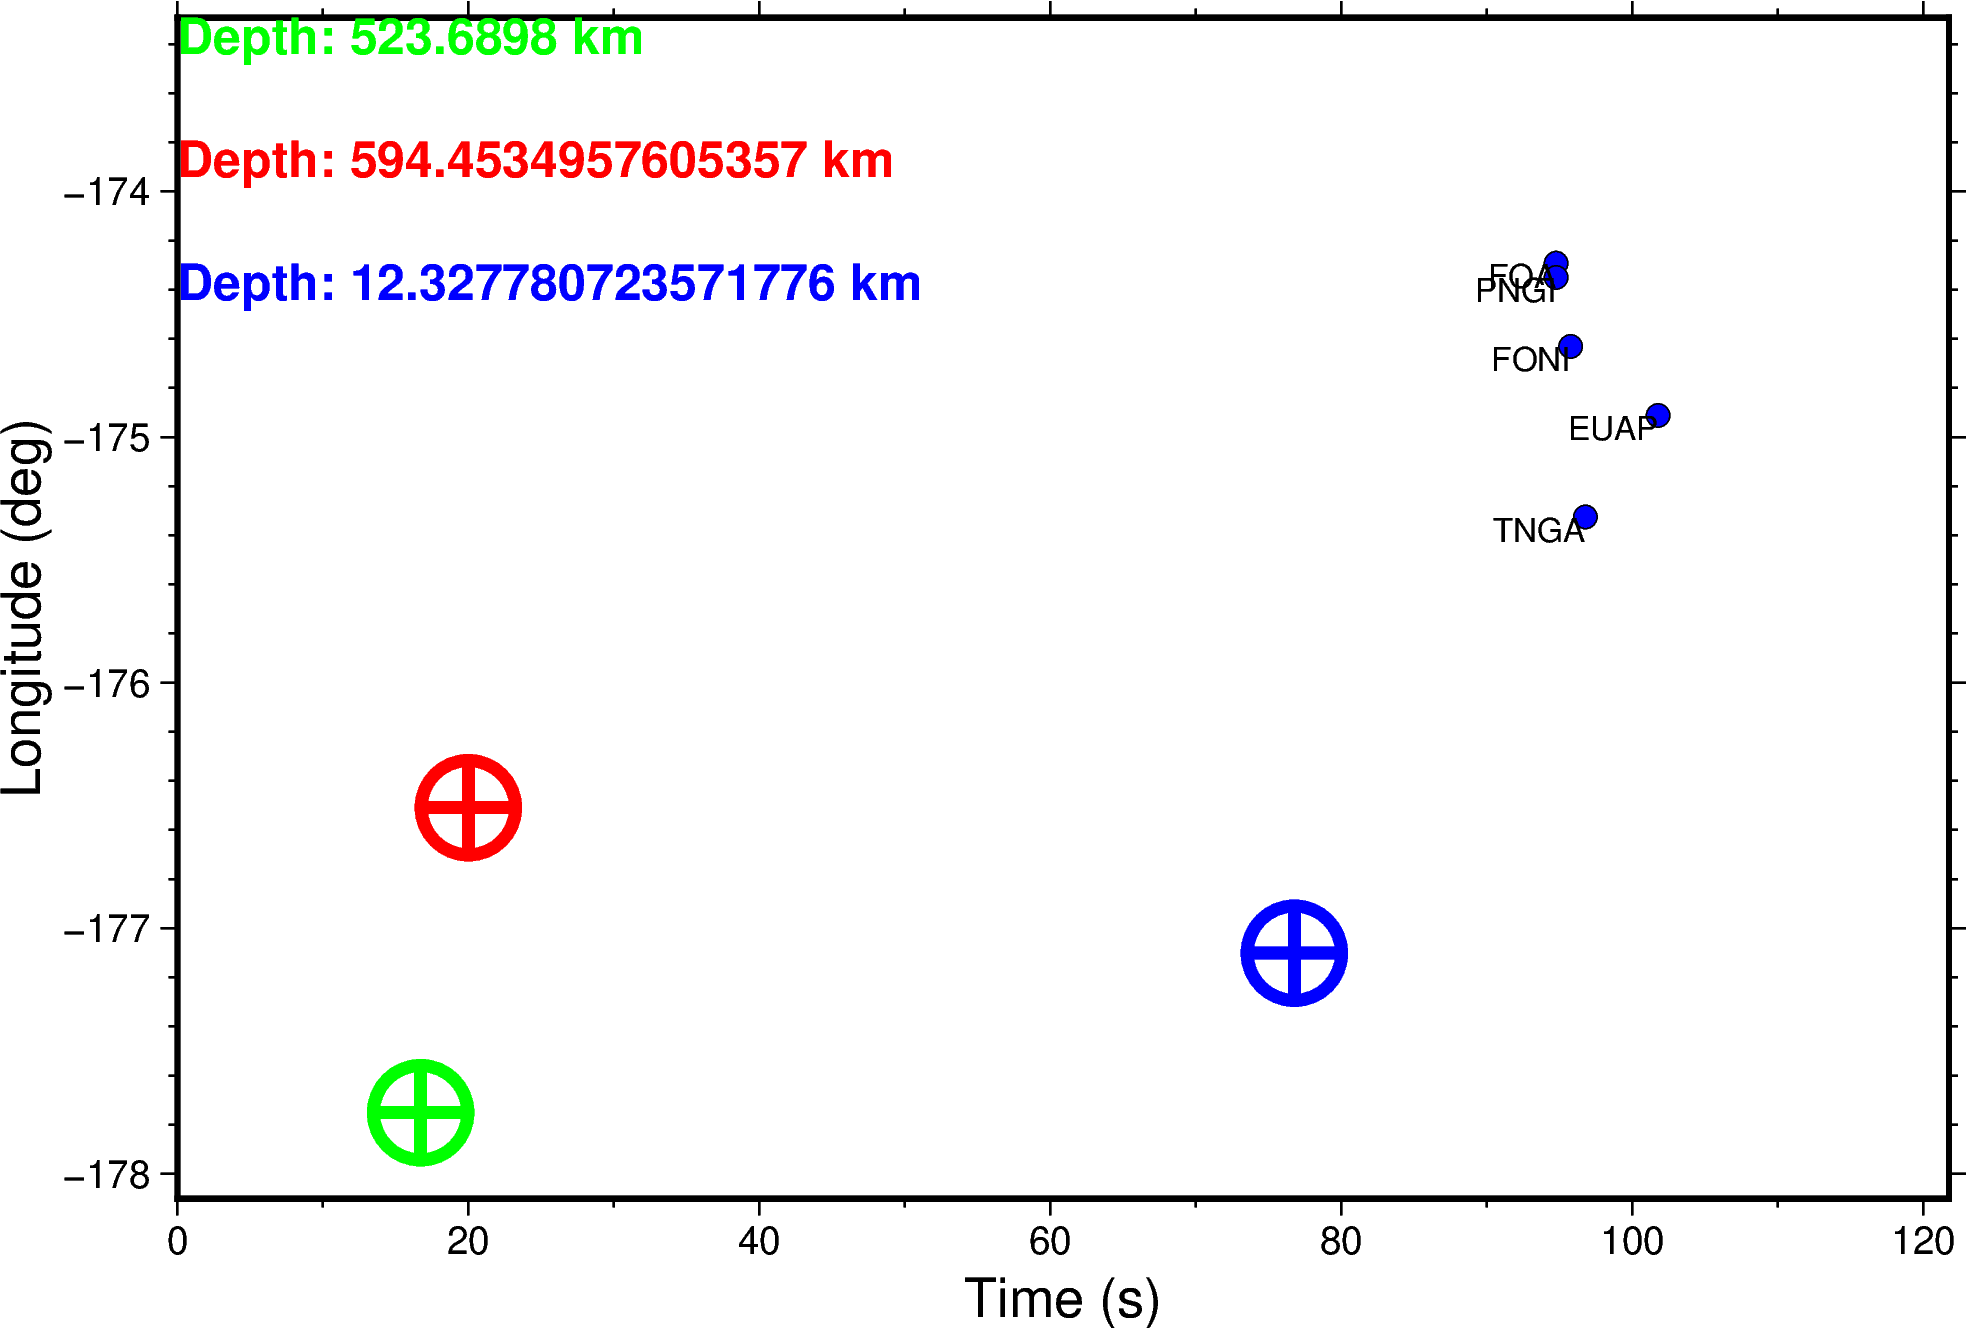

In [22]:
def plot(df, index):
    df = df[df['type'] == 'p']
    df.loc[:, 'tshift'] = df['tshift'] + 20

    fig = pygmt.Figure()

    x = 20
    y = df.iloc[0]['longitude']
    x_local = (df.iloc[0]['time_local']-df.iloc[0]['time']).total_seconds()+20
    y_local = df.iloc[0]['longitude_local']
    # y and y_local might be positive, change to y-360 and y_local-360
    if y > 0:
        y = y - 360
    if y_local > 0:
        y_local = y_local - 360

    # Create a scatter plot using PyGMT
    fig.plot(
        x=df['tshift'],
        y=df['longitude_station'],
        style='c0.2c',
        fill='blue',
        pen='black',
        projection='X15c/10c',
        region=[0, df['tshift'].max()+20, min(df['longitude_station'].min(),
                                              y, y_local)-1, max(df['longitude_station'].max(), y, y_local)+1],
        frame=["WSen", "xaf+lTime (s)", "yaf+lLongitude (deg)"],
    )

    # Plot the event origin location
    fig.plot(x=x, y=y, style="c0.8c", fill=None, pen="3p,red", no_clip=True)
    fig.plot(x=x, y=y, style="+0.8c", pen="3p,red", no_clip=True)

    # Label the station id with non-overlapping
    for i in range(len(df)):
        fig.text(x=df.iloc[i]['tshift'], y=df.iloc[i]['longitude_station'],
                 text=df.iloc[i]['id'].split(".")[1], font='8p', justify='TR')

    ground_truth_x = (
        ground_truth_mapper[index][0]-df.iloc[0]['time']).total_seconds()+20
    ground_truth_y = ground_truth_mapper[index][2]

    # Plot the local event origin location
    fig.plot(x=x_local, y=y_local, style="c0.8c",
             fill=None, pen="3p,blue", no_clip=True)
    fig.plot(x=x_local, y=y_local, style="+0.8c", pen="3p,blue", no_clip=True)

    # Plot the ground truth location
    fig.plot(x=ground_truth_x, y=ground_truth_y, style="c0.8c",
             fill=None, pen="3p,green", no_clip=True)
    fig.plot(x=ground_truth_x, y=ground_truth_y,
             style="+0.8c", pen="3p,green", no_clip=True)
    print(ground_truth_x, ground_truth_y)

    # text in the same color as origin for the event depth, put the text at the upper left of the figure
    fig.text(x=0, y=max(df['longitude_station'].max(), y, y_local)+1,
                text=f"Depth: {ground_truth_mapper[index][3]} km", font="12p,Helvetica-Bold,green", justify='TL')
    fig.text(x=0, y=max(df['longitude_station'].max(), y, y_local)+0.5,
                text=f"Depth: {df.iloc[0]['z(km)']} km", font="12p,Helvetica-Bold,red", justify='TL')
    fig.text(x=0, y=max(df['longitude_station'].max(), y, y_local),
                text=f"Depth: {df.iloc[0]['z(km)_local']} km", font="12p,Helvetica-Bold,blue", justify='TL')

    fig.show()


for index in range(8):
    plot(df_global_list[index], index)


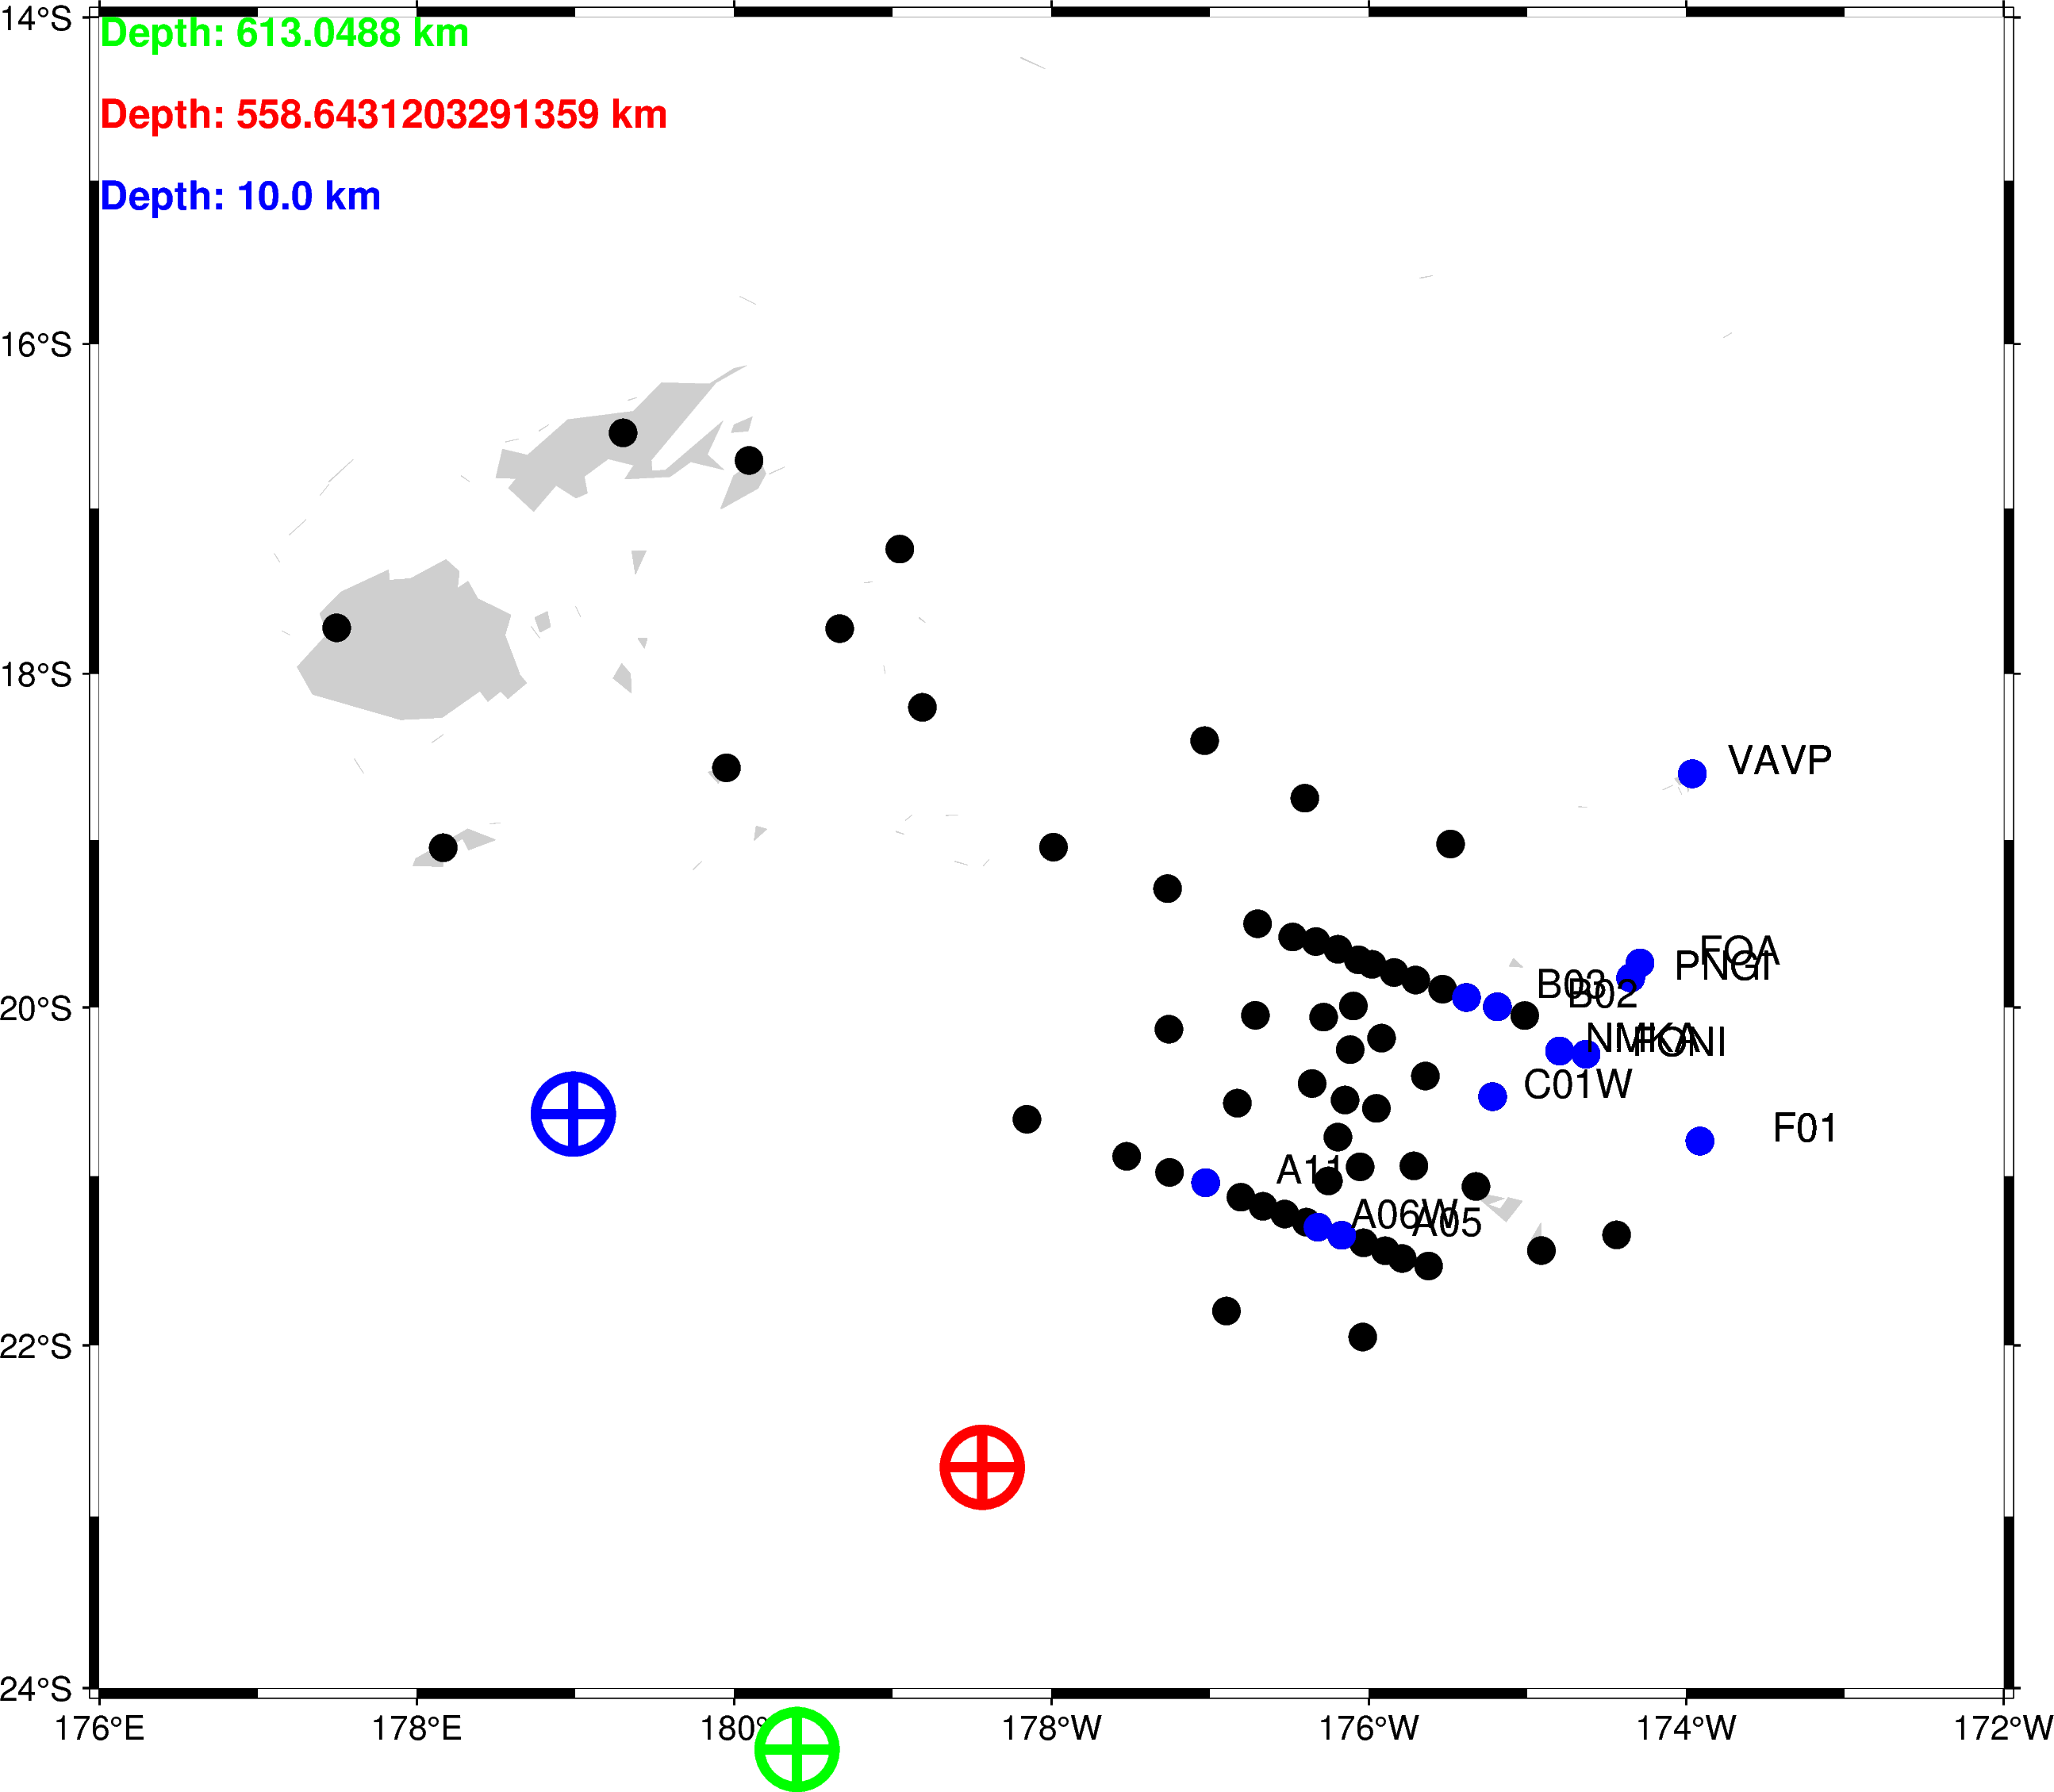

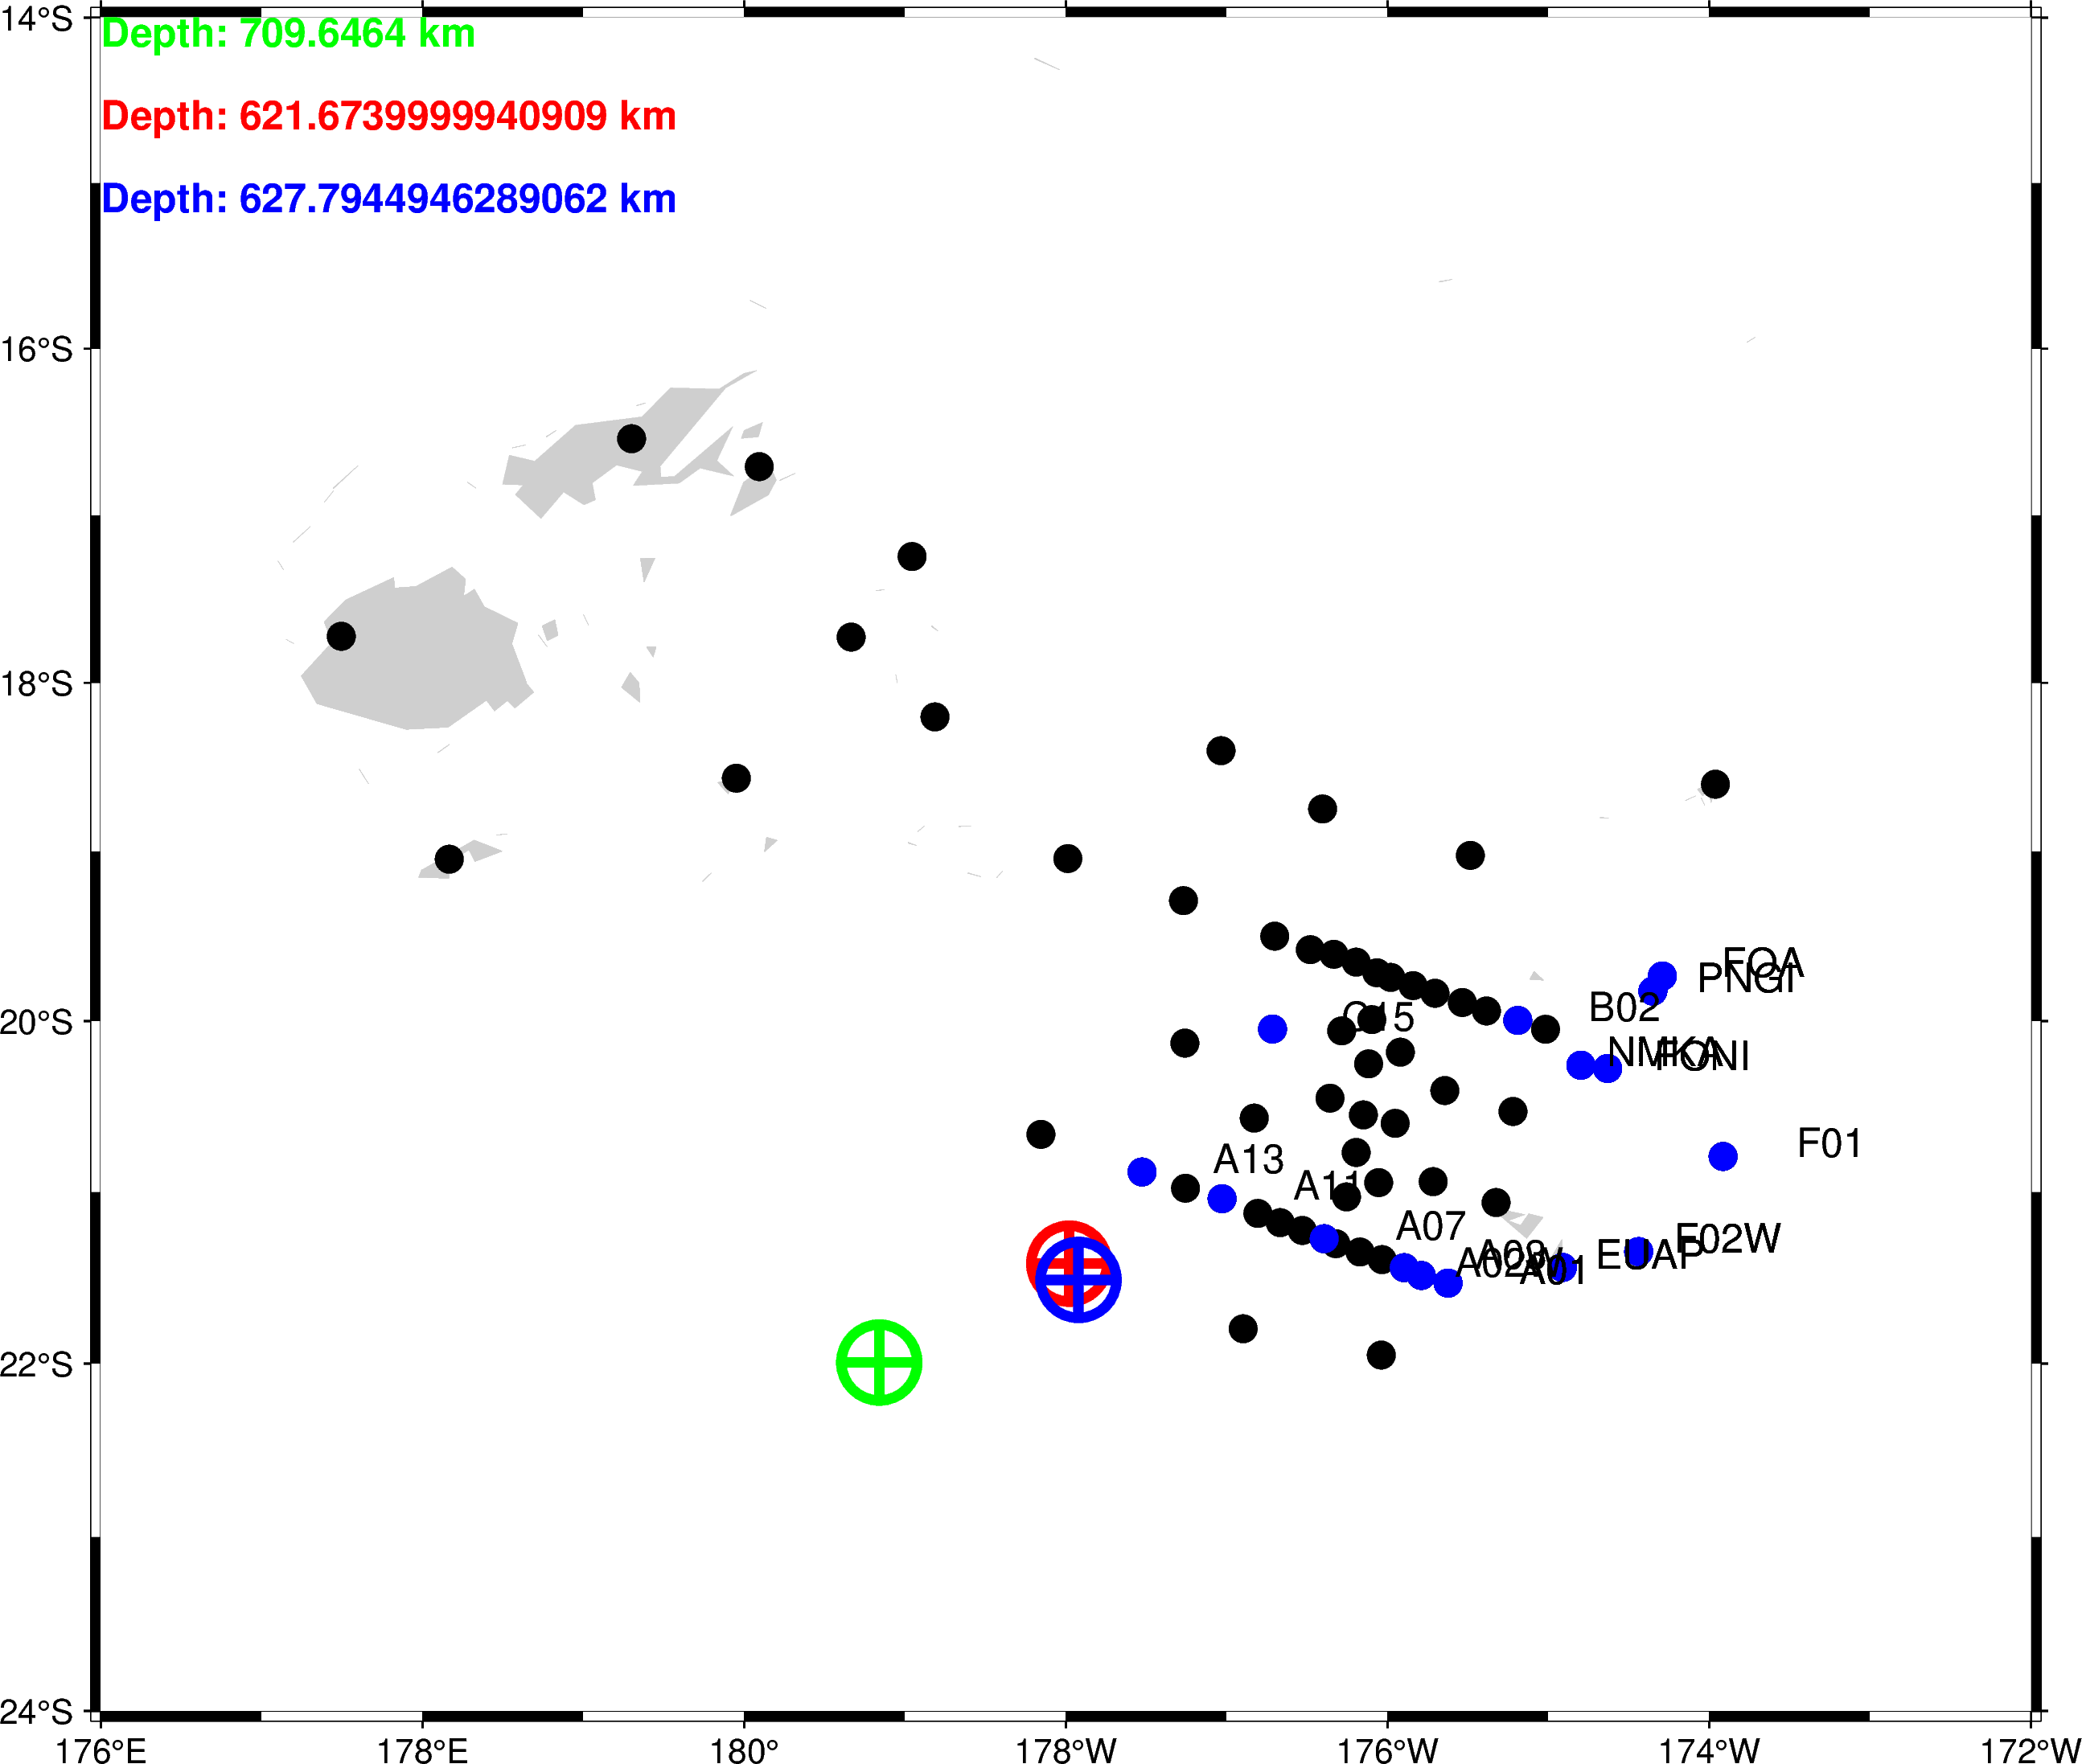

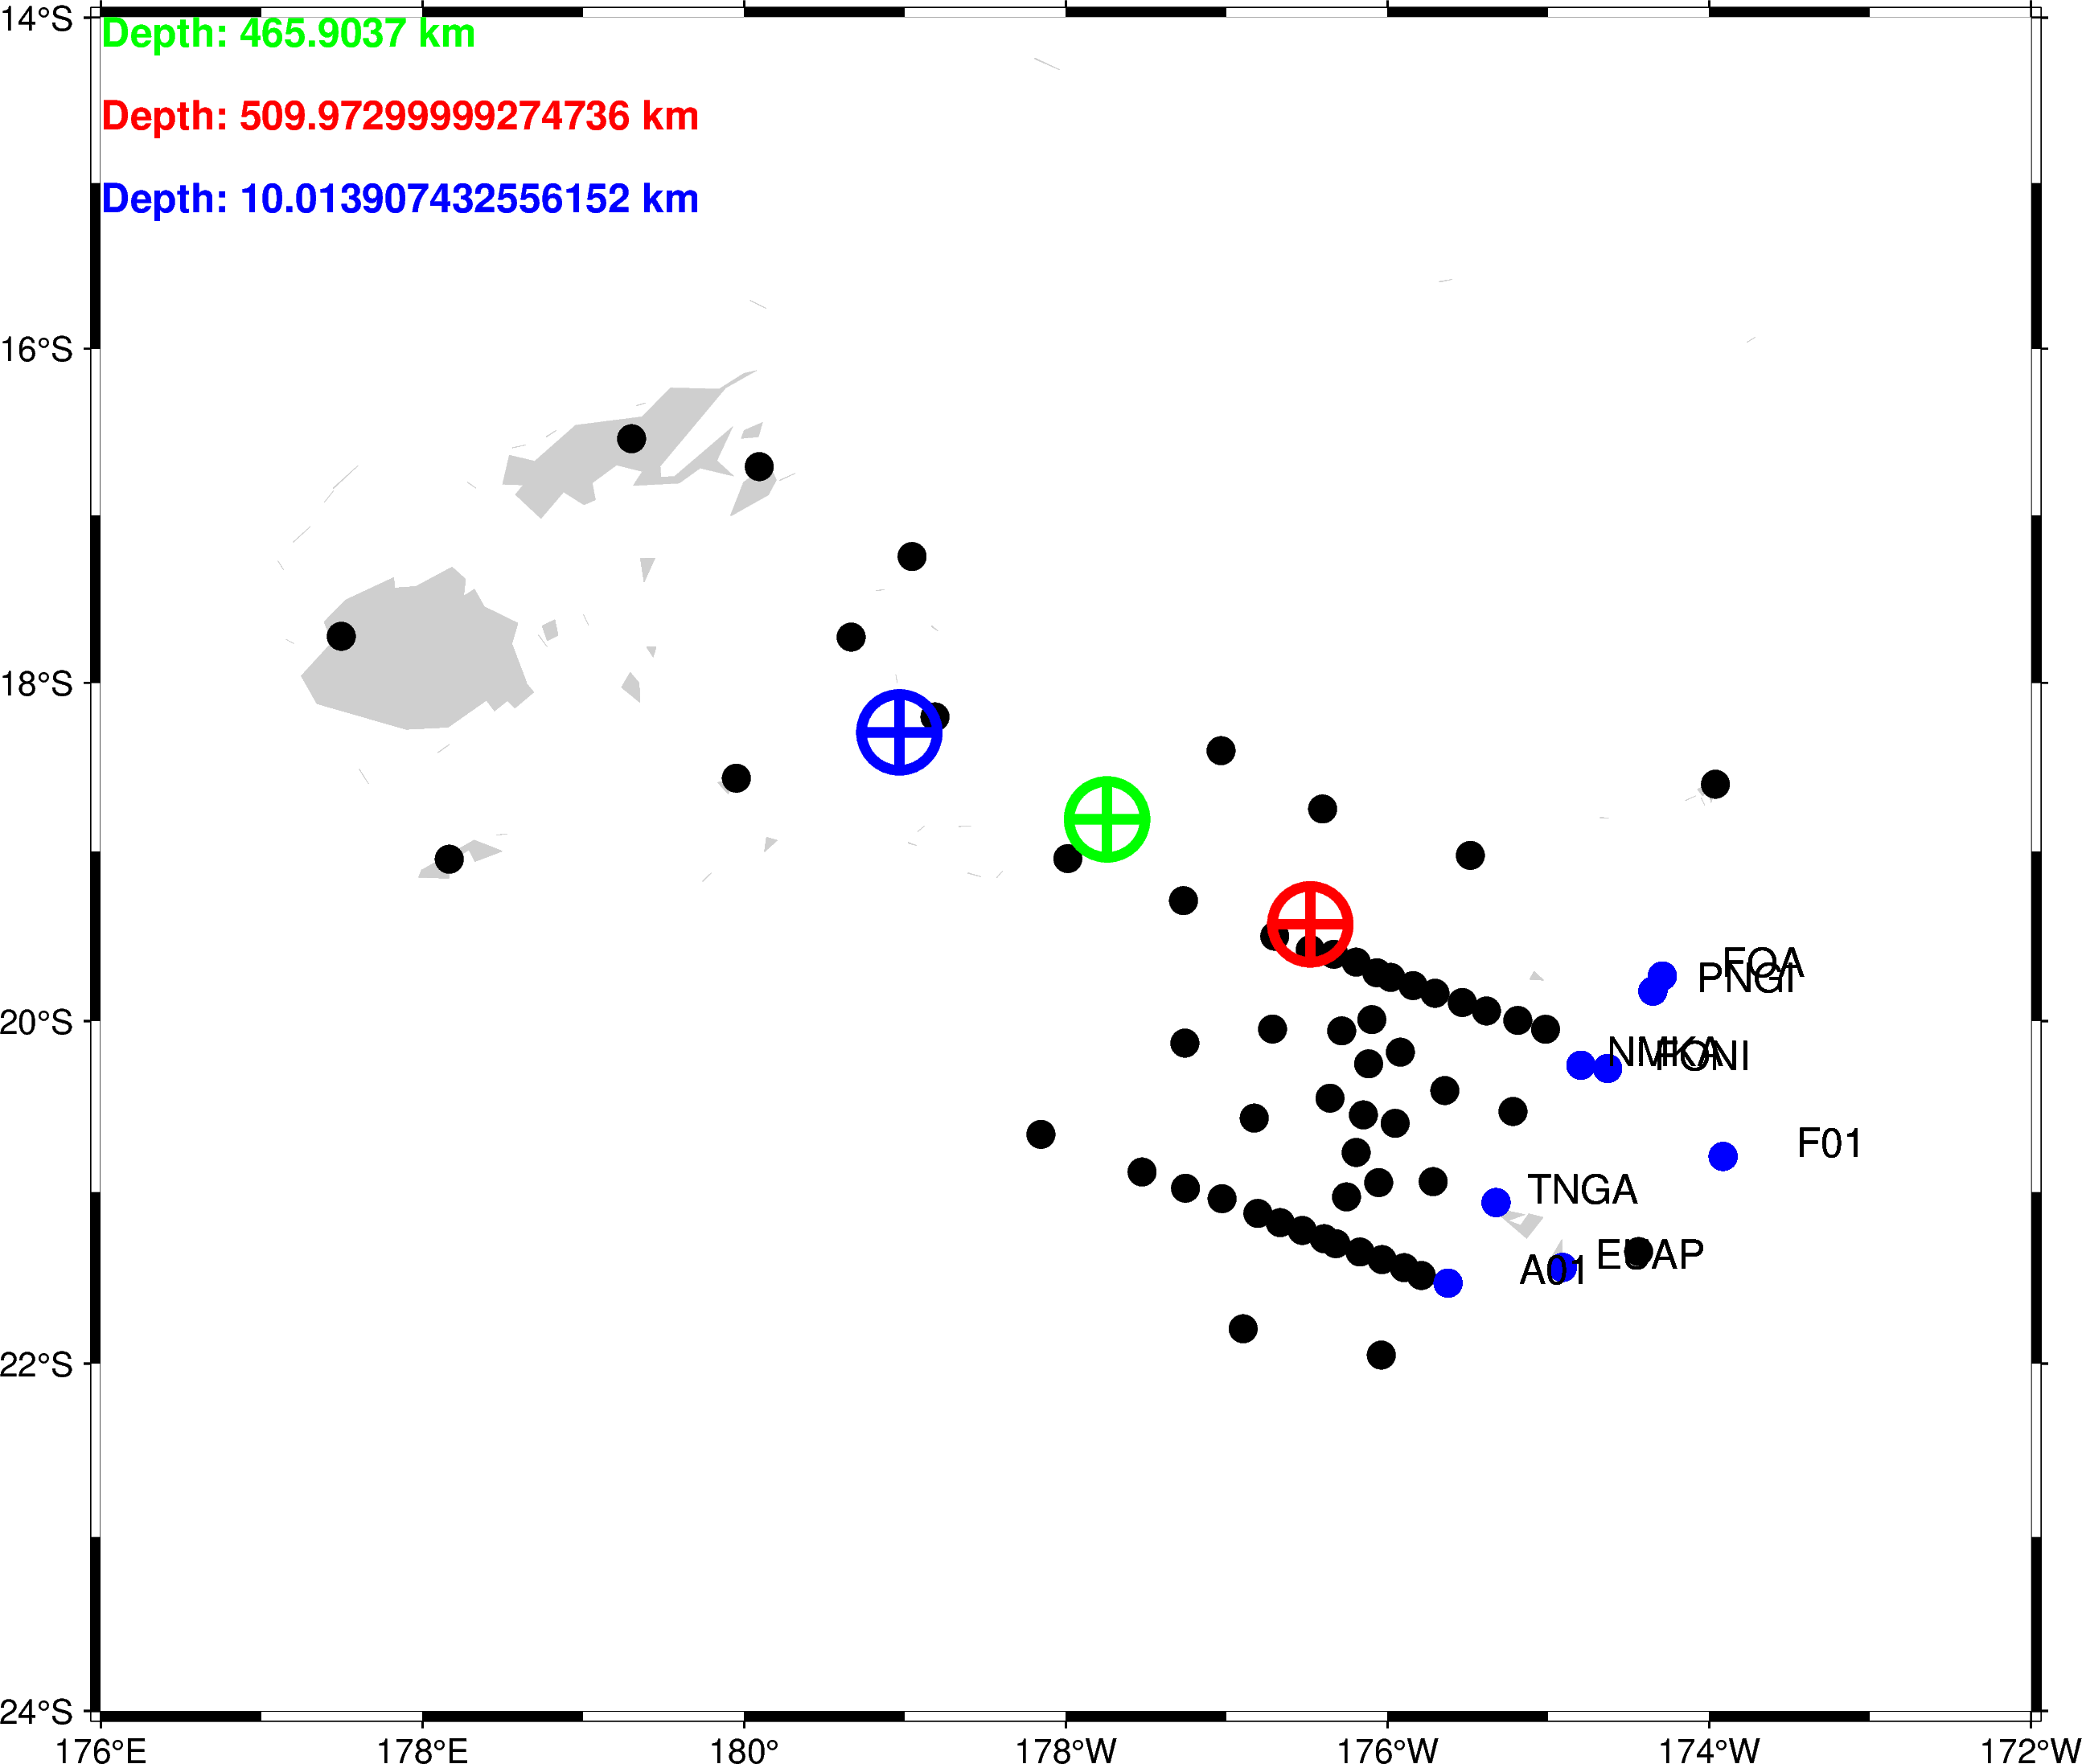

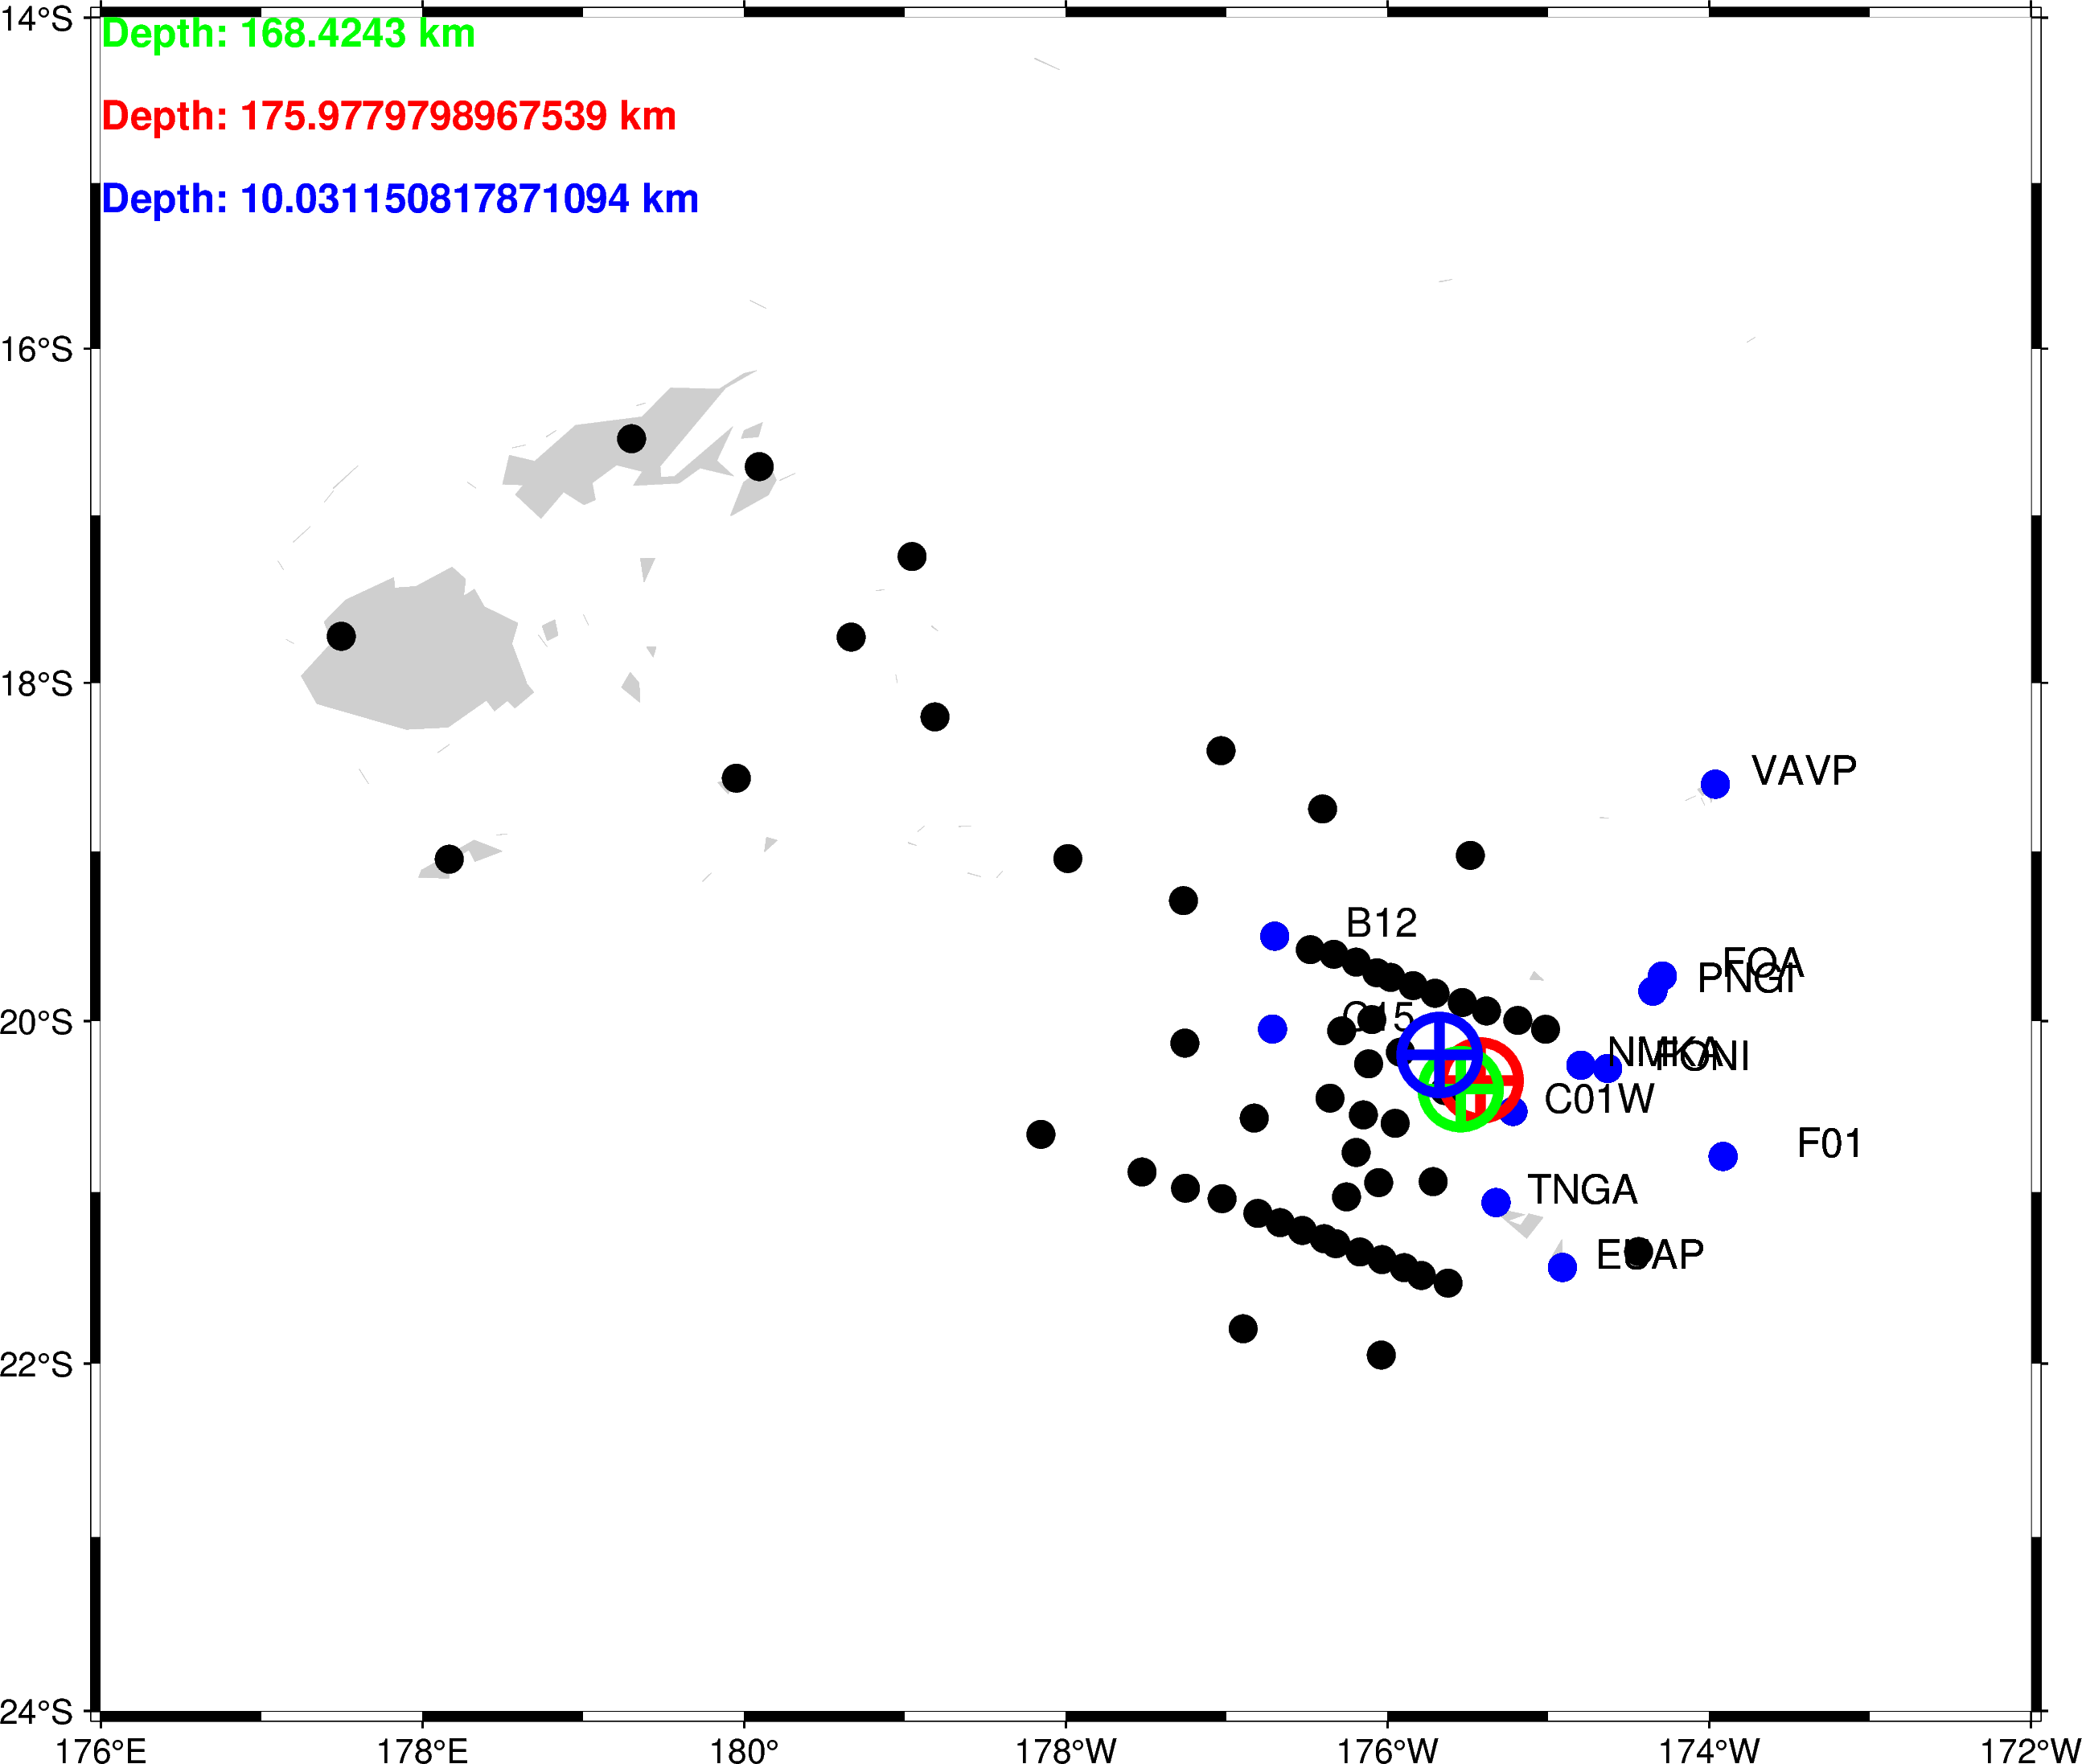

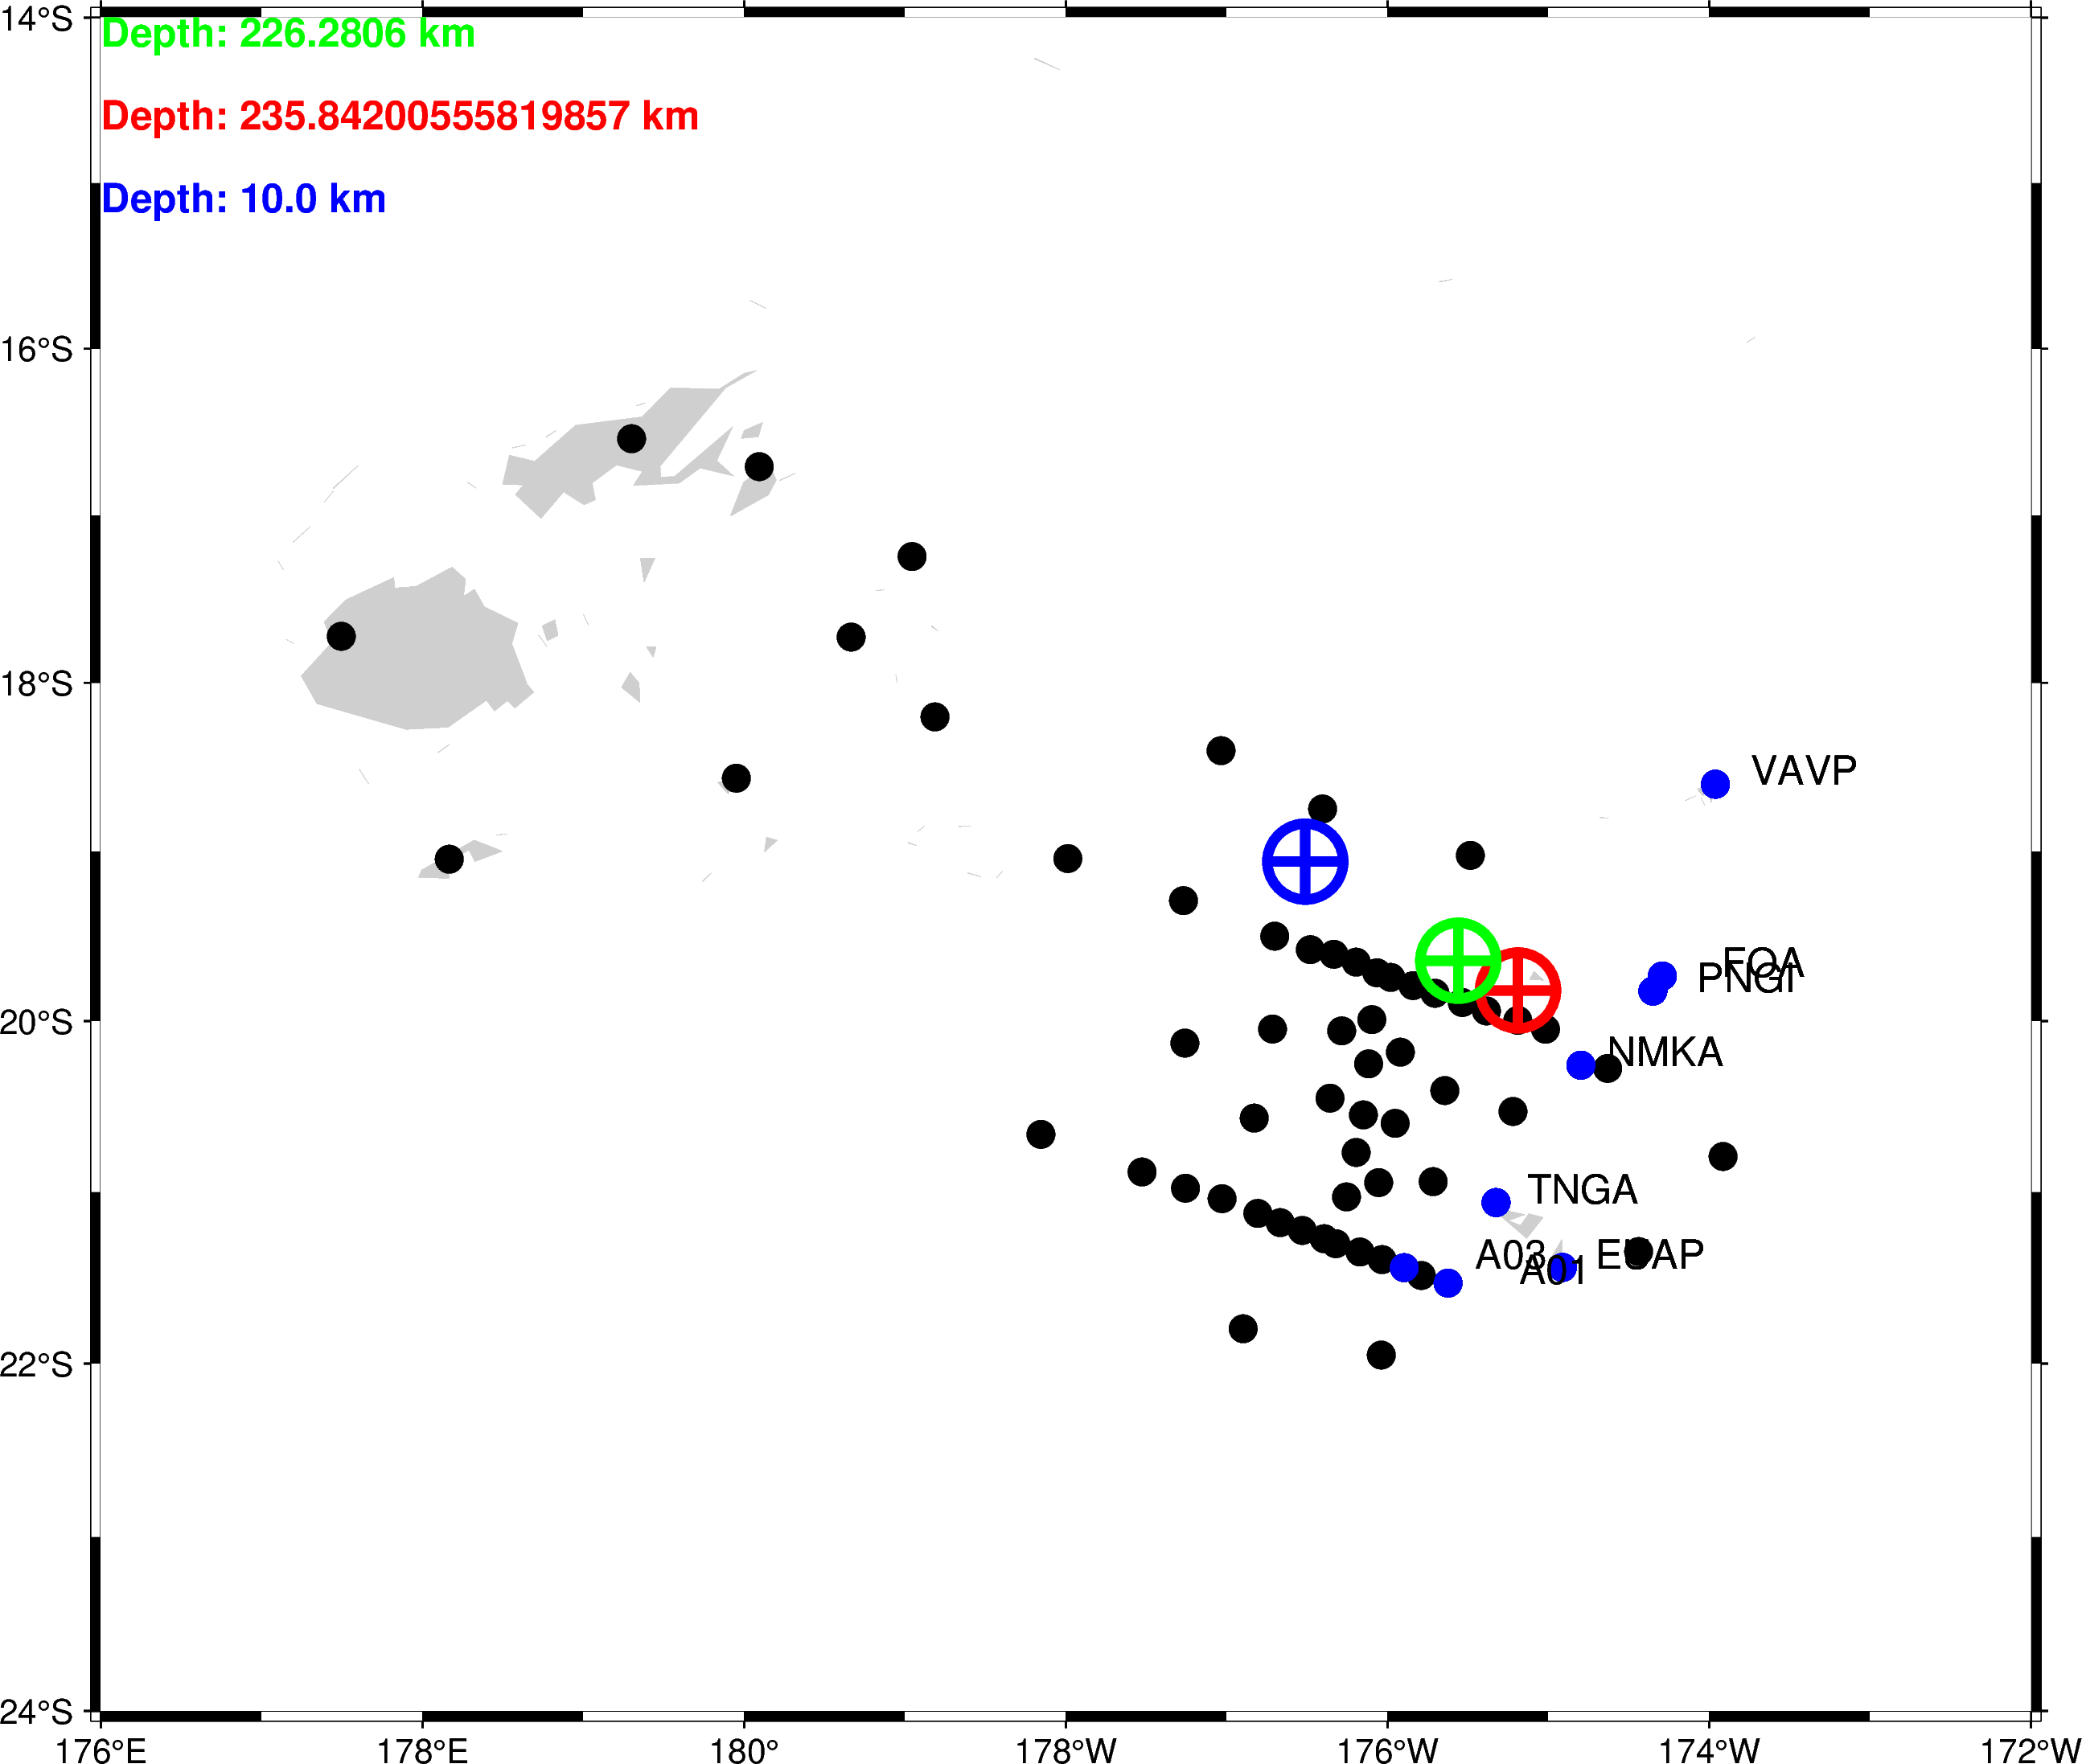

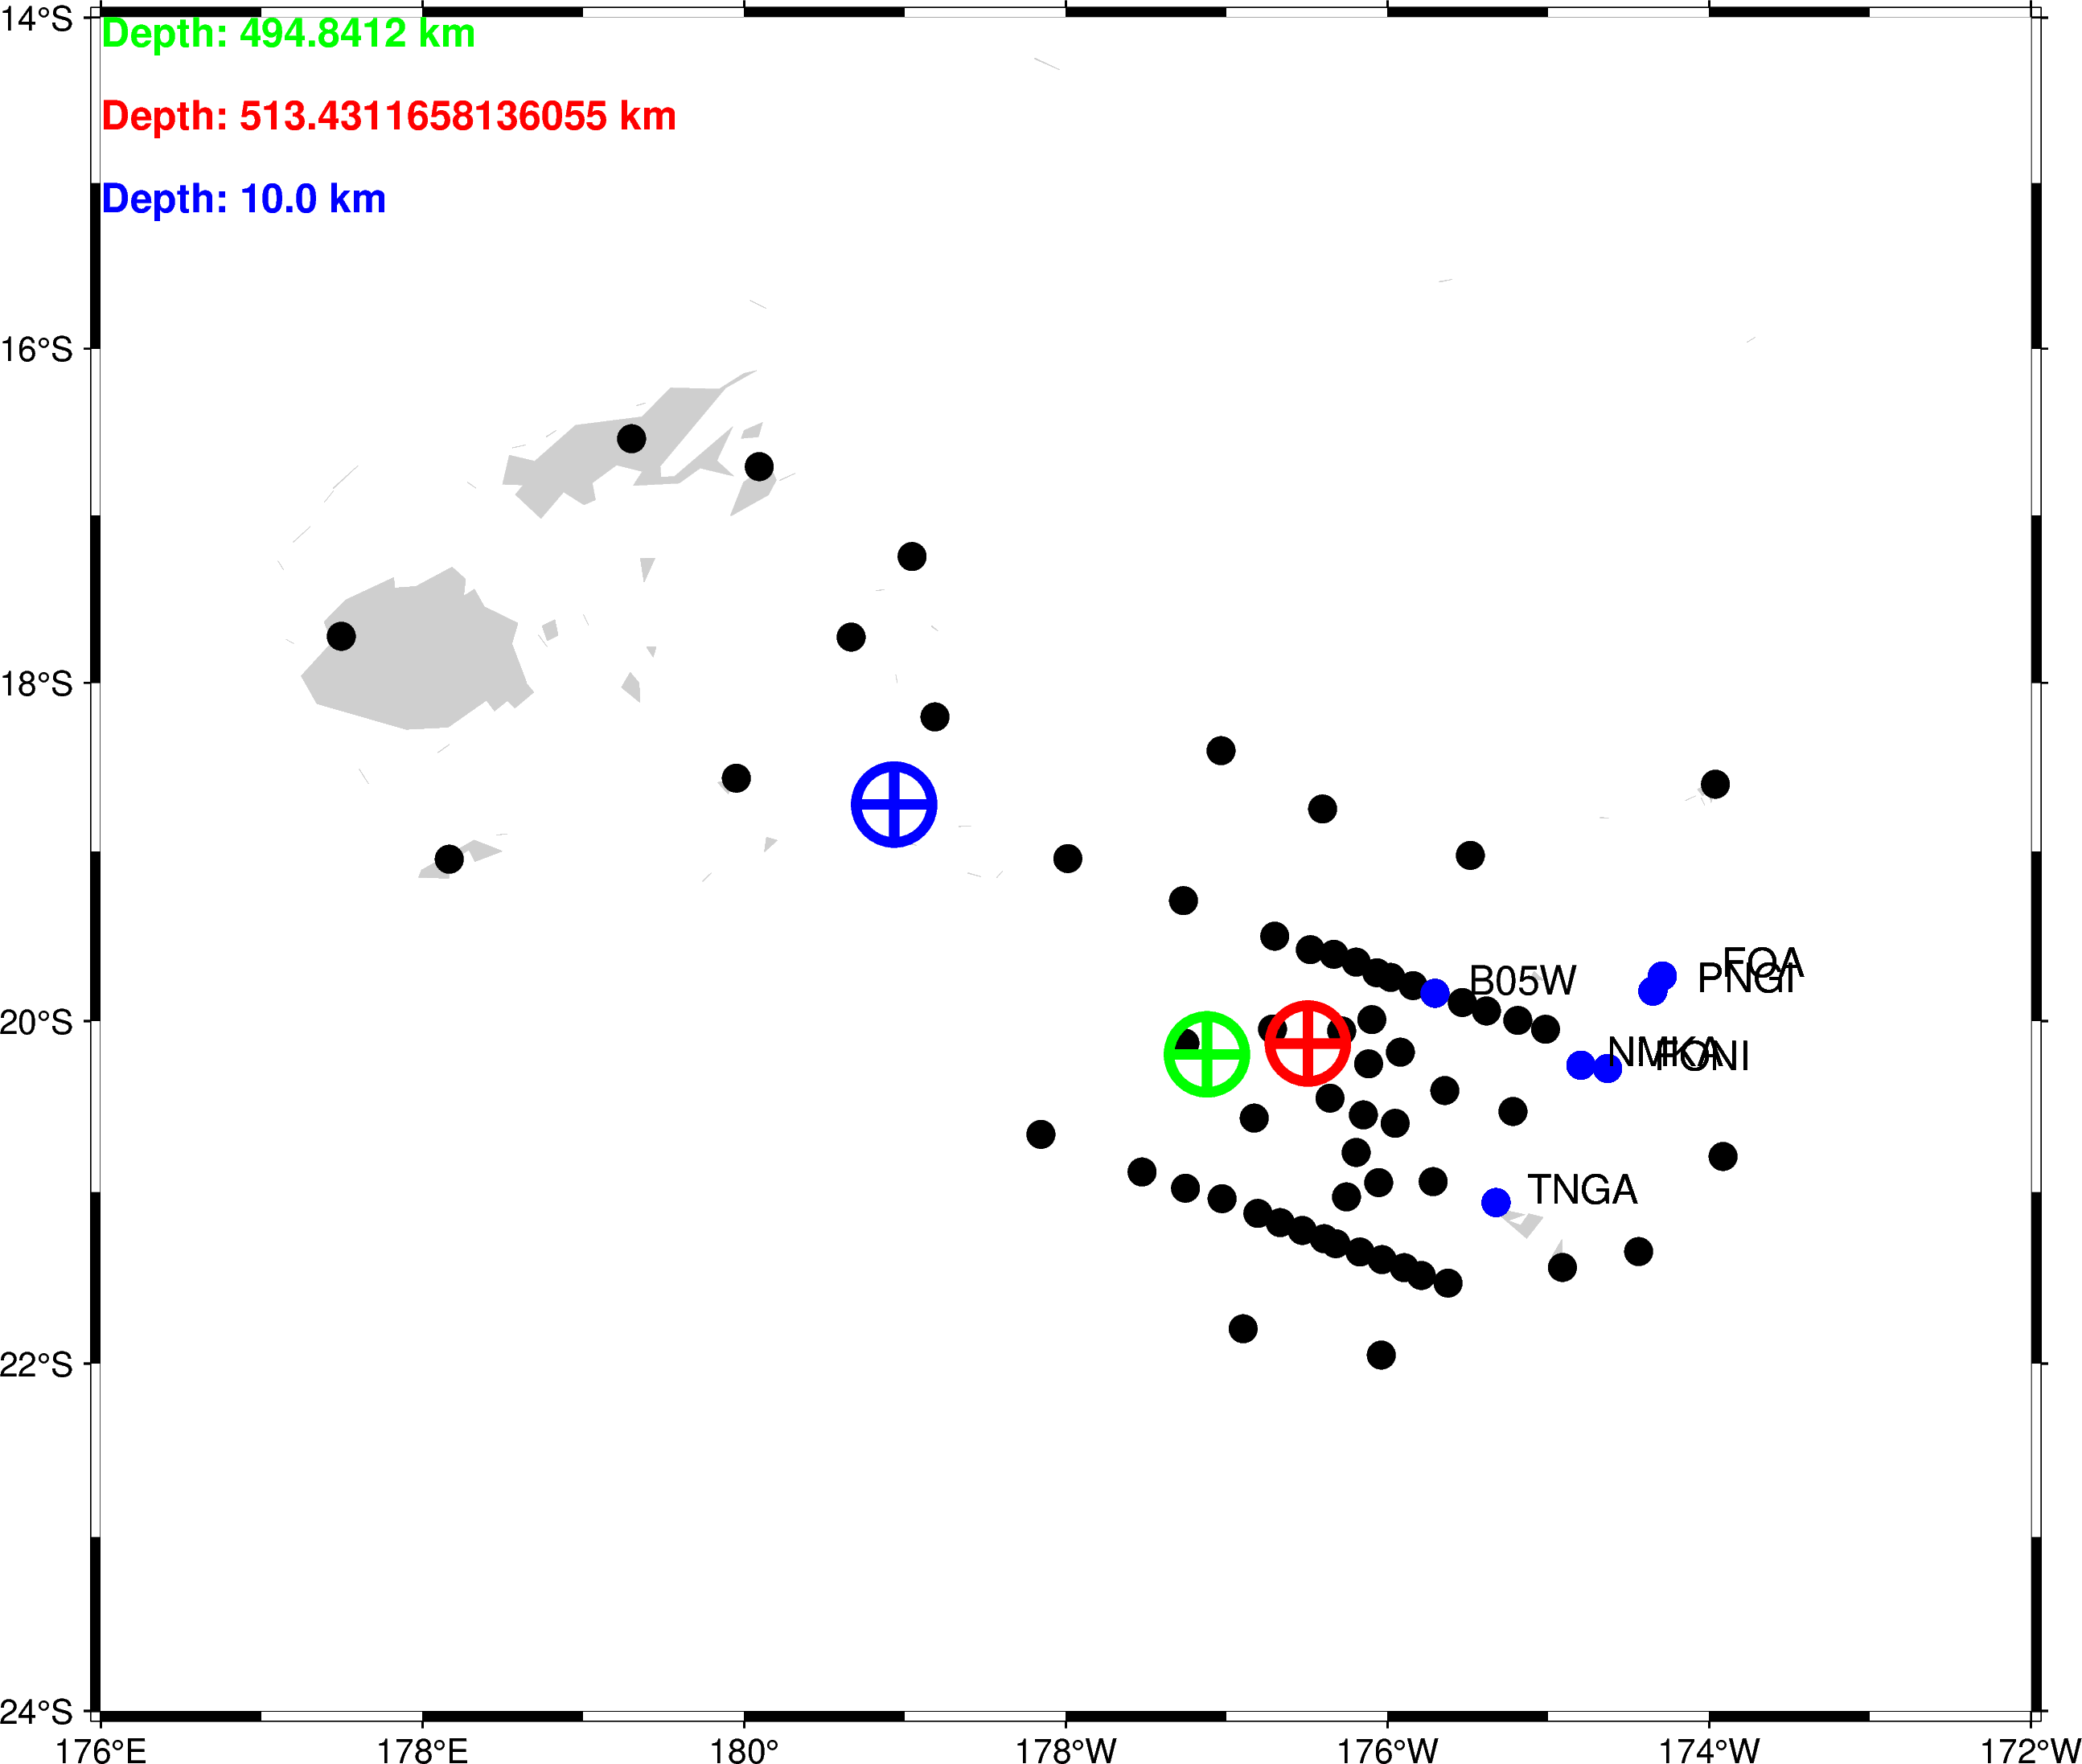

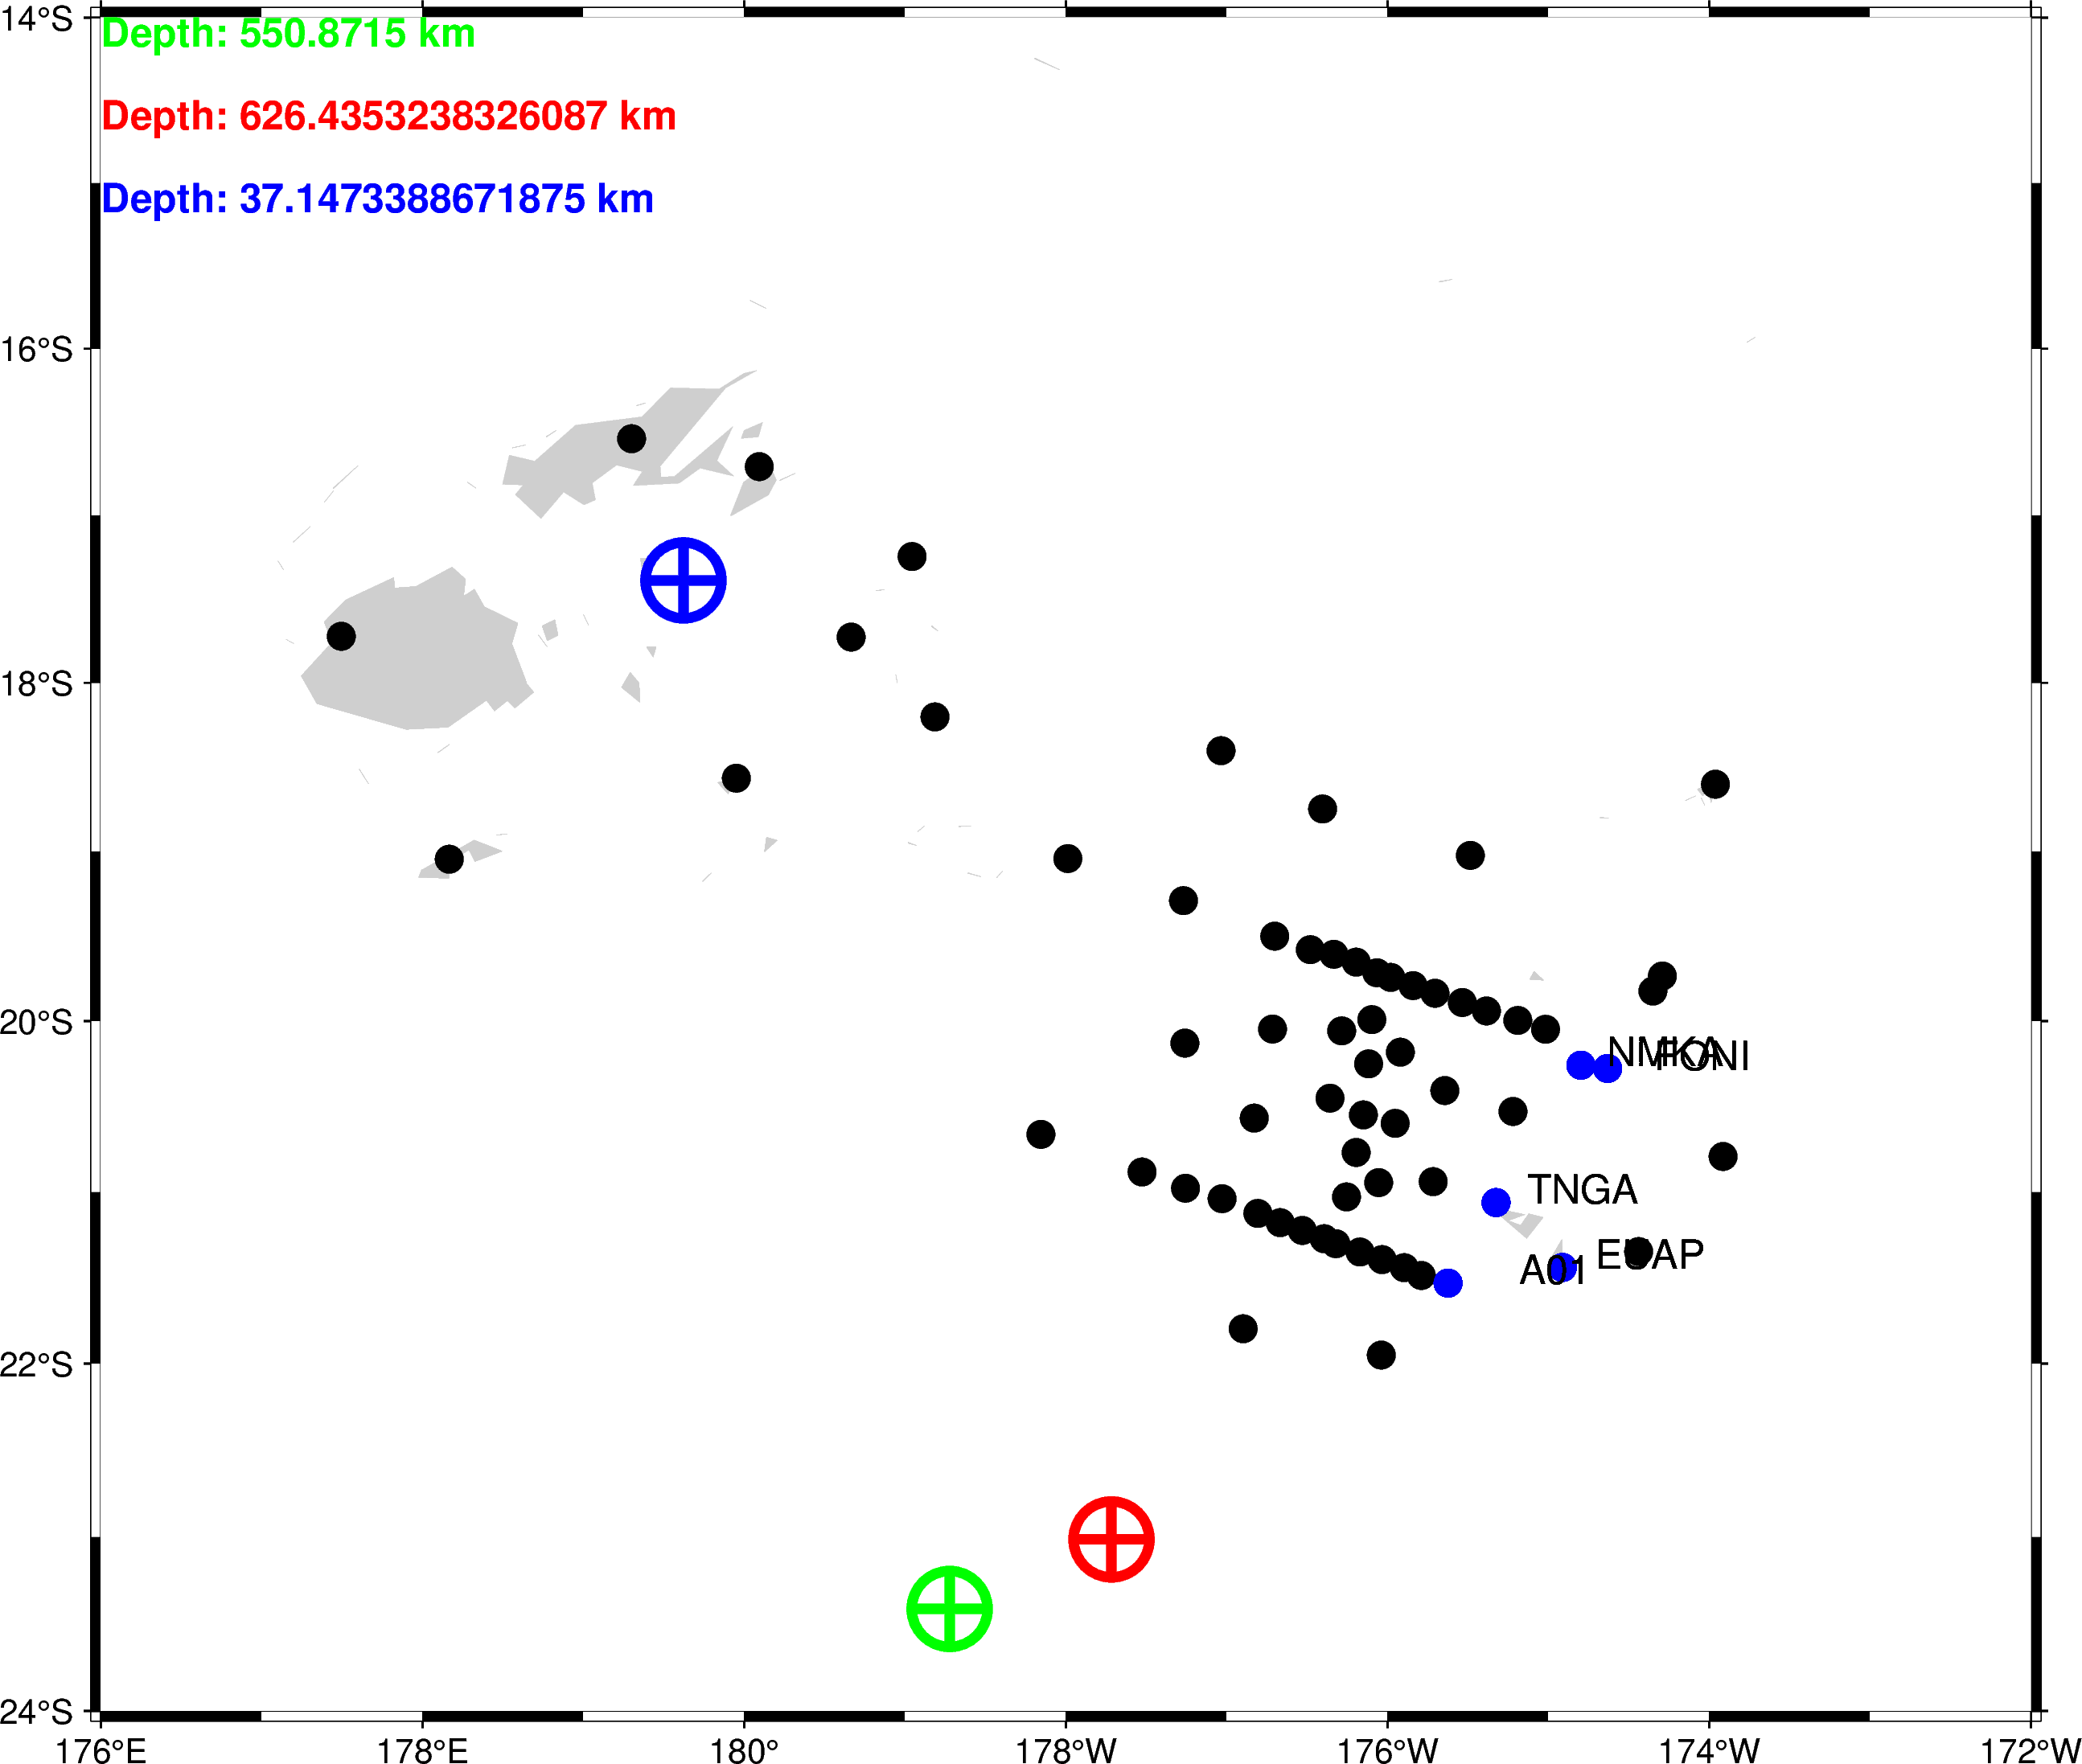

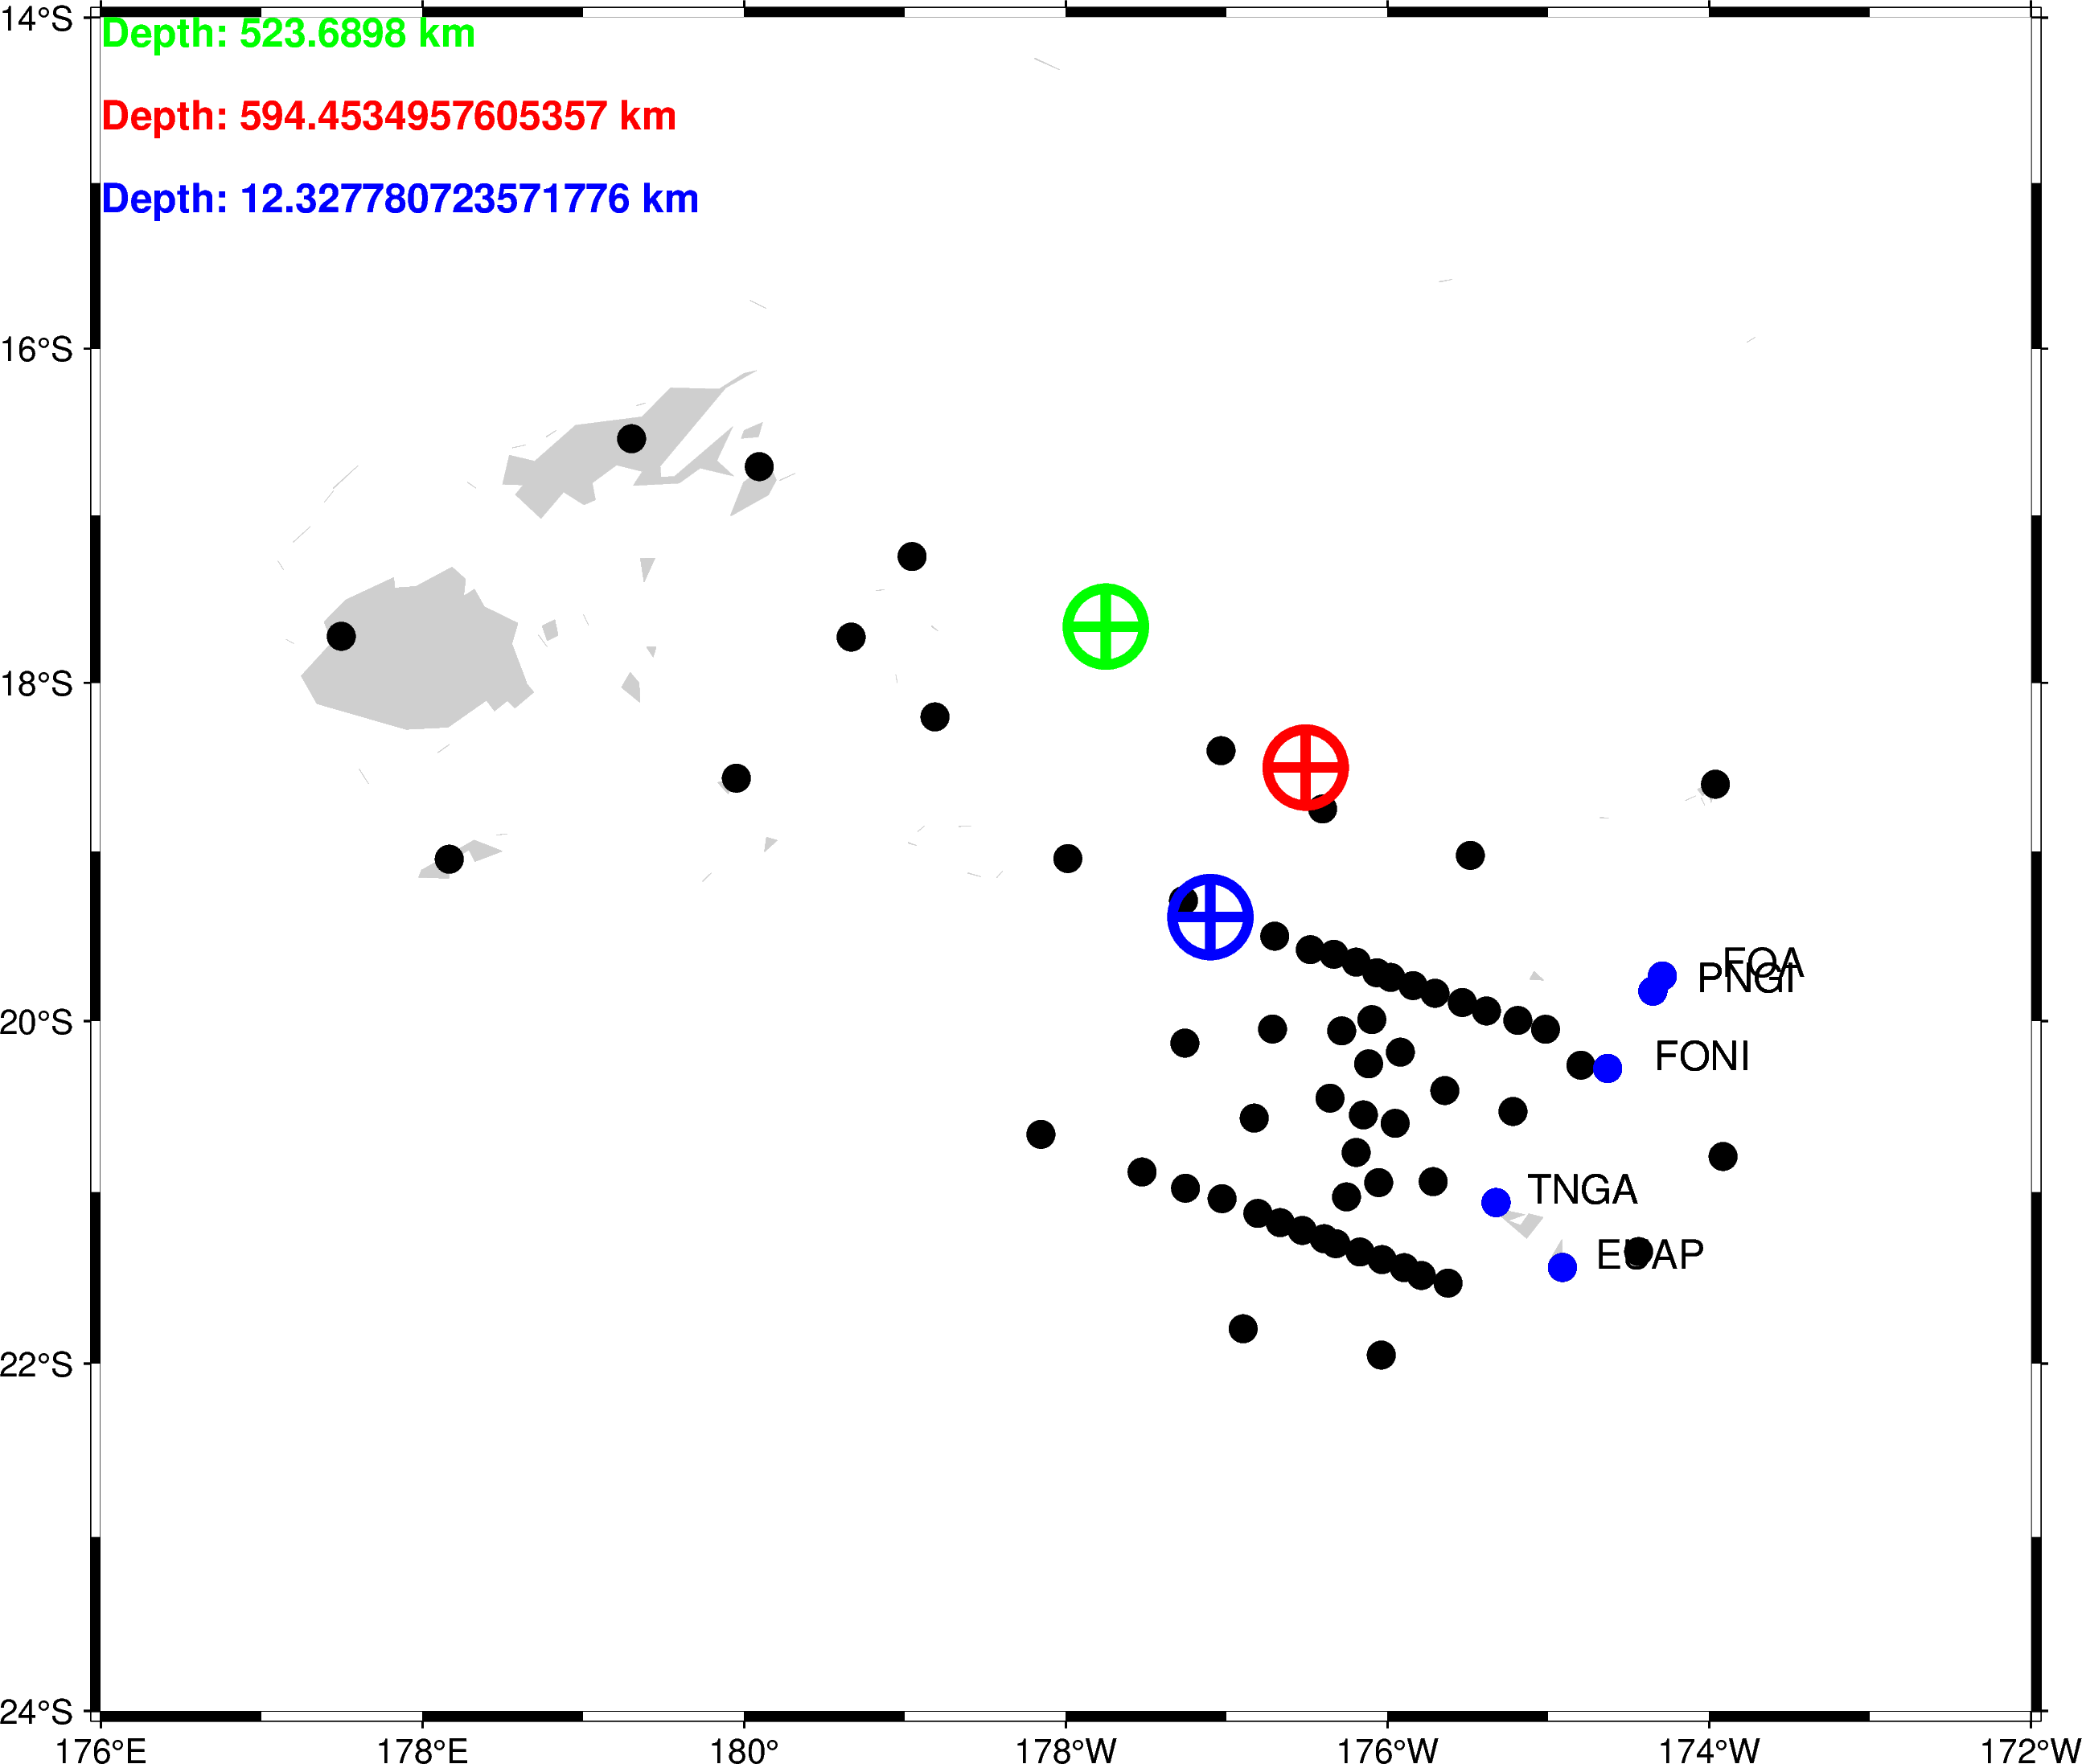

In [24]:
# show the stations' locations on the map using pygmt
def show_map(df,index):
    REGION=[-184, -172, -24, -14]

    fig = pygmt.Figure()
    fig.basemap(region=REGION, projection="M8i",
                        frame=["WSen", "xafg", "yafg"])
    fig.coast(water="white", resolution="l", land="GRAY81",
                borders=["1/0.1p,black"], lakes=["GRAY81"])
    fig.plot(x=stations['longitude'], y=stations['latitude'], style="c0.3c", fill="black")
    # plot longitude and latitude of stations in df in red color
    fig.plot(x=df['longitude_station'], y=df['latitude_station'], style="c0.3c", fill="blue")
    # also text the station id
    for i in range(len(df)):
        fig.text(x=df.iloc[i]['longitude_station'], y=df.iloc[i]['latitude_station'], text=df.iloc[i]['id'].split(".")[1], font='12p', justify='TR',offset="1.5c/0.3c")
    # plot event origin (longitude, latitude) in big circle with no fill
    # print(df.iloc[0]['longitude'], df.iloc[0]['latitude'])
    fig.plot(x=df.iloc[0]['longitude'], y=df.iloc[0]['latitude'], style="c0.8c", fill=None, pen="3p,red",no_clip=True)
    fig.plot(x=df.iloc[0]['longitude'], y=df.iloc[0]['latitude'], style="+0.8c", pen="3p,red",no_clip=True)
    # fig.text(x=df.iloc[0]['longitude'], y=df.iloc[0]['latitude'], text="INV", font='12p', justify='TR',offset="1.5c/0.3c")
    # print(ground_truth_mapper[index][1],ground_truth_mapper[index][2])
    fig.plot(x=ground_truth_mapper[index][2], y=ground_truth_mapper[index][1], style="c0.8c", fill=None, pen="3p,green",no_clip=True)
    fig.plot(x=ground_truth_mapper[index][2], y=ground_truth_mapper[index][1], style="+0.8c", pen="3p,green",no_clip=True)
    # fig.text(x=ground_truth_mapper[index][2], y=ground_truth_mapper[index][1], text="GT", font='12p', justify='BL',offset="1.5c/0.3c")

    # plot local event origin (longitude, latitude) in big circle with no fill
    fig.plot(x=df.iloc[0]['longitude_local'], y=df.iloc[0]['latitude_local'], style="c0.8c", fill=None, pen="3p,blue",no_clip=True)
    fig.plot(x=df.iloc[0]['longitude_local'], y=df.iloc[0]['latitude_local'], style="+0.8c", pen="3p,blue",no_clip=True)

    # text in the same color as origin for the event depth, put the text at the upper left of the figure
    fig.text(x=176, y=-15+1,
                text=f"Depth: {ground_truth_mapper[index][3]} km", font="12p,Helvetica-Bold,green", justify='TL')
    fig.text(x=176, y=-15+0.5,
                text=f"Depth: {df.iloc[0]['z(km)']} km", font="12p,Helvetica-Bold,red", justify='TL')
    fig.text(x=176, y=-15,
                text=f"Depth: {df.iloc[0]['z(km)_local']} km", font="12p,Helvetica-Bold,blue", justify='TL')

    fig.show()

# show_map(df_global_list[0],0)
for index in range(8):
    show_map(df_global_list[index],index)